# Trabalho Final - Aprendizado de Máquina

**Nome:** Frederico Dolher Souza Baker

**Matrícula:** 2021031513

## Introdução

Após considerar diversas opções e explorar datasets disponíveis publicamente, percebi que muitos desses conjuntos de dados já haviam sido amplamente analisados e eu não conseguiria adicionar muitas novidades. Buscando um contexto real para aplicar os aprendizados, surgiu a oportunidade durante uma visita ao meu barbeiro. Solicitei a ele os dados de sua barbearia, e ele gentilmente os forneceu. Esse dataset real proporcionaria uma aplicação prática e significativa das técnicas de aprendizado de máquina vistas em sala.

Os dados fornecidos incluem registros desde a abertura da barbearia em 2016, com a identificação dos clientes anonimizada por meio de IDs e as datas em que cada cliente visitou a barbearia. Infelizmente, não dispomos de informações demográficas dos clientes ou sobre os tipos de serviços realizados, o que limita algumas análises potenciais. No entanto, esses dados ainda permitem explorar questões relevantes e aplicar técnicas de aprendizado de máquina de forma prática.

A seguir, vamos iniciar com uma análise exploratória dos dados disponíveis.


In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split


## Análise Exploratória

### Formatação dos Dados

In [123]:
df = pd.read_csv('presenca_clientes_limpo.csv')
df.head()

,id,data,primeira_visita
0,1,2016-07-28,2016-07-28
1,1,2016-10-27,2016-07-28
2,1,2016-12-20,2016-07-28
3,1,2017-03-03,2016-07-28
4,1,2017-04-26,2016-07-28


In [124]:
df['data'] = pd.to_datetime(df['data'])

df['dia_da_semana'] = df['data'].dt.day_name()
days_week_dict = {
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}
df['dia_da_semana'] = df['dia_da_semana'].map(days_week_dict)

df['mês'] = df['data'].dt.month
df['ano'] = df['data'].dt.year

df.head()

,id,data,primeira_visita,dia_da_semana,mês,ano
0,1,2016-07-28,2016-07-28,Quinta-feira,7,2016
1,1,2016-10-27,2016-07-28,Quinta-feira,10,2016
2,1,2016-12-20,2016-07-28,Terça-feira,12,2016
3,1,2017-03-03,2016-07-28,Sexta-feira,3,2017
4,1,2017-04-26,2016-07-28,Quarta-feira,4,2017


In [110]:
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13427 entries, 0 to 13426
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               13427 non-null  int64         
 1   data             13427 non-null  datetime64[ns]
 2   primeira_visita  13427 non-null  object        
 3   dia_da_semana    13427 non-null  object        
 4   mês              13427 non-null  int32         
 5   ano              13427 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(2)
memory usage: 524.6+ KB


(None,
                  id                           data           mês           ano
 count  13427.000000                          13427  13427.000000  13427.000000
 mean     468.326134  2020-05-13 06:33:09.960527360      6.735980   2019.846727
 min        1.000000            2016-07-28 00:00:00      1.000000   2016.000000
 25%      259.000000            2018-07-12 00:00:00      4.000000   2018.000000
 50%      461.000000            2020-03-14 00:00:00      7.000000   2020.000000
 75%      673.000000            2022-03-15 00:00:00     10.000000   2022.000000
 max     1007.000000            2024-05-21 00:00:00     12.000000   2024.000000
 std      269.390946                            NaN      3.493893      2.210449)

### Distribuição Temporal das Visitas

#### Distribuição das Visitas por Ano

O primeiro gráfico que analisamos mostra a distribuição das visitas por ano, com o número de visitas no eixo Y e o ano no eixo X. É evidente que 2019 foi um ano atípico, com um número de visitas significativamente maior do que nos outros anos. Entre 2017 e 2022, o número de visitas manteve-se relativamente constante. No entanto, houve uma queda significativa em 2023, com o número de visitas reduzido para 1.492, bem abaixo da média anterior de cerca de 1.700 visitas. Os dados dos anos de 2016 e 2024 são menos relevantes para esta análise, uma vez que a barbearia abriu no segundo semestre de 2016 e os dados de 2024 foram coletados apenas no primeiro semestre.

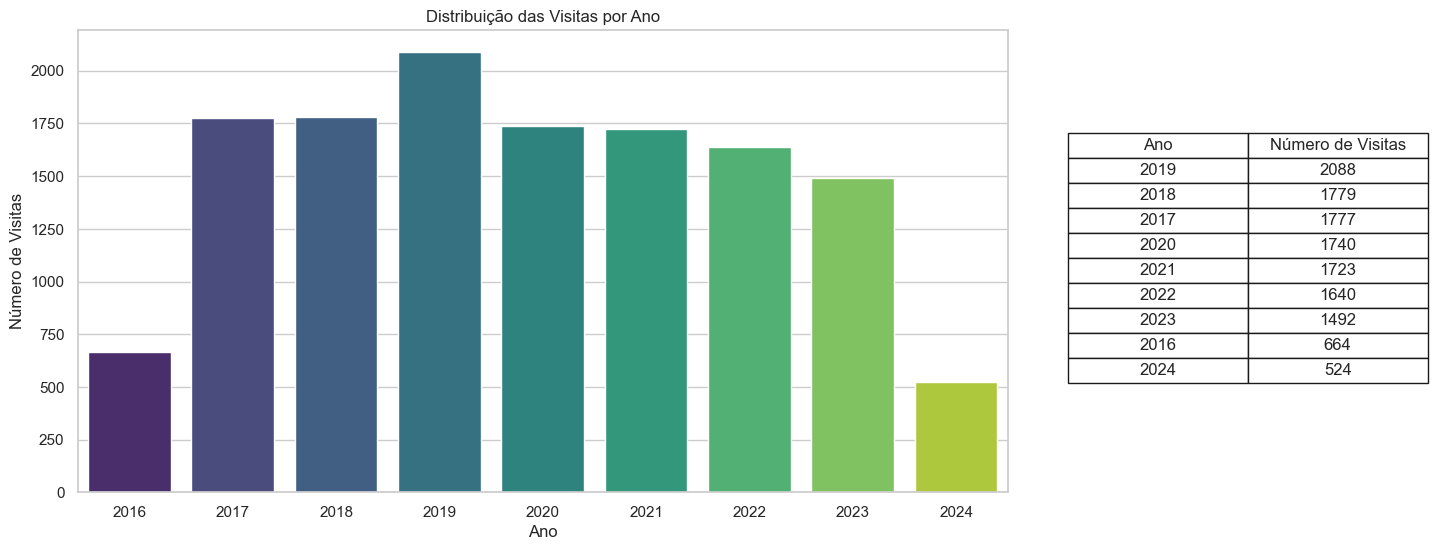

In [6]:
visits_by_year = df['ano'].value_counts().sort_values(ascending=False).reset_index()
visits_by_year.columns = ['Ano', 'Número de Visitas']

sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de barras
sns.countplot(x='ano', data=df, palette='viridis', ax=ax1)
ax1.set_title('Distribuição das Visitas por Ano')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Visitas')

ax2 = fig.add_axes([1, 0.1, 0.20, 0.8])  # [left, bottom, width, height]
ax2.axis('off')
tbl = ax2.table(cellText=visits_by_year.values, colLabels=visits_by_year.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.5, 1.5)

plt.show()

#### Distribuição das Visitas por Mês

No gráfico de distribuição das visitas por mês, observamos uma proximidade no número de visitas ao longo dos meses, com alguns pontos de destaque. Dezembro tem um número significativamente maior de visitas, enquanto janeiro apresenta um número bem menor, possivelmente devido às festas de fim de ano e férias. Observa-se também uma queda nas visitas em junho e julho, que podem ser períodos de férias, embora seja difícil fazer uma inferência precisa.

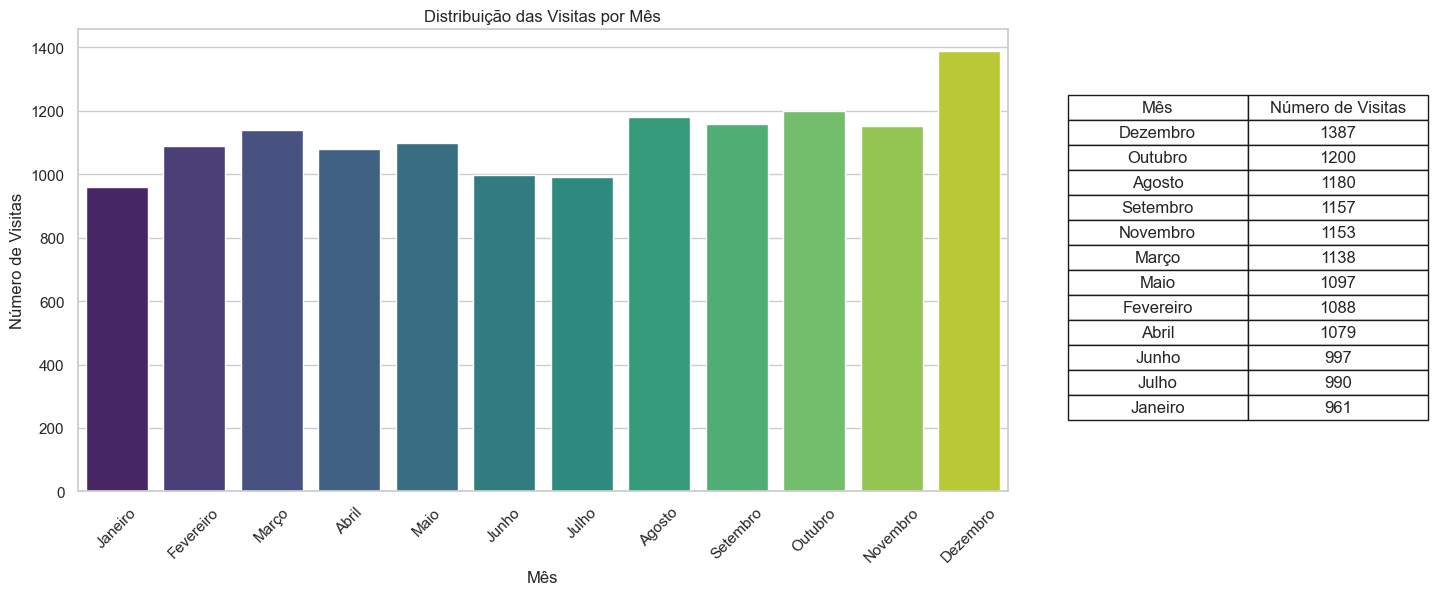

In [7]:
visits_by_month = df['mês'].value_counts().sort_values(ascending=False).reset_index()
visits_by_month.columns = ['Mês', 'Número de Visitas']

months = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
visits_by_month['Mês'] = visits_by_month['Mês'].apply(lambda x: months[x-1])

sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.countplot(x='mês', data=df, palette='viridis', ax=ax1, order=range(1, 13))
ax1.set_title('Distribuição das Visitas por Mês')
ax1.set_xlabel('Mês')
ax1.set_ylabel('Número de Visitas')
ax1.set_xticklabels(months, rotation=45)

ax2 = fig.add_axes([1, 0.1, 0.20, 0.8])
ax2.axis('off')
tbl = ax2.table(cellText=visits_by_month.values, colLabels=visits_by_month.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.5, 1.5)

plt.show()

#### Média de Visitas por Mês

Analisando o valor médio de visitas por mês ao longo dos anos, março destaca-se com uma média alta de 173 clientes, sugerindo a presença de um outlier em algum ano. Janeiro e agosto apresentam valores médios mais baixos, com janeiro refletindo a tendência observada anteriormente de menor movimento no início do ano.

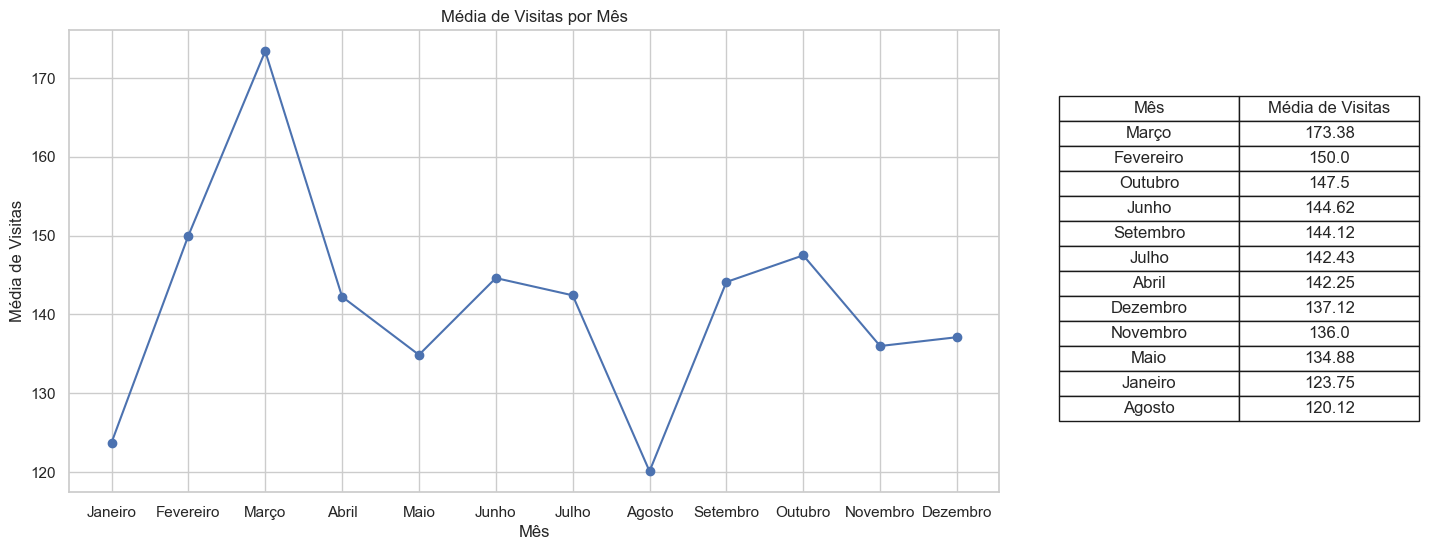

In [8]:
mean_per_month = []

months = df['mês'].unique()
years = df['ano'].unique()

for month in months:
    df_month = df[df['mês'] == month]
    num_visits_by_year = []
    
    for year in years:
        num_visits = df_month[df_month['ano'] == year].shape[0]
        if num_visits > 0:
            num_visits_by_year.append(num_visits)
    
    mean_per_month.append(round(np.mean(num_visits_by_year), 2))

months = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

mean_per_month_df = pd.DataFrame({'Mês': months, 'Média de Visitas': mean_per_month})
mean_per_month_df = mean_per_month_df.sort_values(by='Média de Visitas', ascending=False)

# Plotar a média de visitas por mês
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de linha
ax1.plot(months, mean_per_month, marker='o')
ax1.set_title('Média de Visitas por Mês')
ax1.set_xlabel('Mês')
ax1.set_ylabel('Média de Visitas')

# Adicionar tabela ao lado do gráfico
ax2 = fig.add_axes([1, 0.1, 0.2, 0.8])  # [left, bottom, width, height]
ax2.axis('off')
tbl = ax2.table(cellText=mean_per_month_df.values, colLabels=mean_per_month_df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.5, 1.5)

plt.show()


#### Distribuição das Visitas por Dia da Semana

A análise da distribuição das visitas por dia da semana revela que a barbearia não abre às segundas-feiras e domingos. Sexta-feira é o dia com o maior número de visitas, seguido por sábado. Curiosamente, quinta-feira tem um número de visitas similar ao sábado, possivelmente devido a horários de funcionamento mais longos durante a semana.

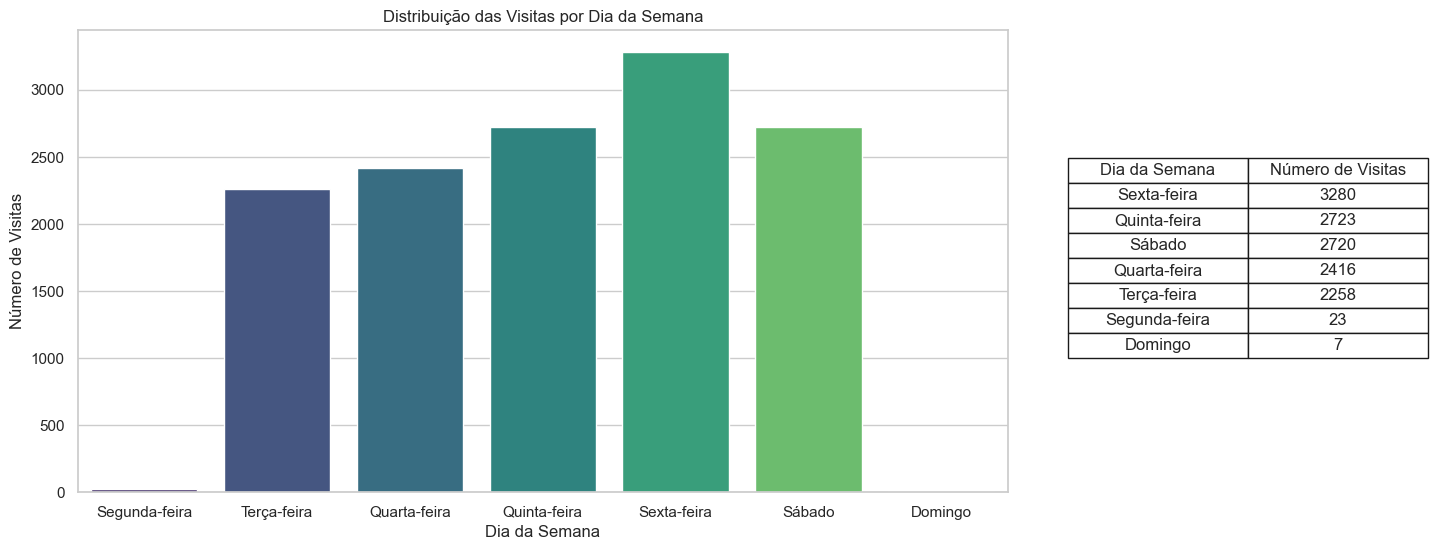

In [9]:
visits_by_day_of_week = df['dia_da_semana'].value_counts().reindex(
    ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
).reset_index()
visits_by_day_of_week.columns = ['Dia da Semana', 'Número de Visitas']
visits_by_day_of_week = visits_by_day_of_week.sort_values(by='Número de Visitas', ascending=False)

sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.countplot(x='dia_da_semana', data=df, palette='viridis', order=['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo'], ax=ax1)
ax1.set_title('Distribuição das Visitas por Dia da Semana')
ax1.set_xlabel('Dia da Semana')
ax1.set_ylabel('Número de Visitas')

ax2 = fig.add_axes([1, 0.1, 0.2, 0.8])
ax2.axis('off')
tbl = ax2.table(cellText=visits_by_day_of_week.values, colLabels=visits_by_day_of_week.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.5, 1.5)

plt.show()

#### Média de Visitas por Dia da Semana

A média de visitas por dia da semana acompanha de perto o valor absoluto das visitas, com sexta-feira tendo a média mais alta. No entanto, a média de sábado é ligeiramente maior do que a de quinta-feira, refletindo um movimento consistente nos fins de semana.

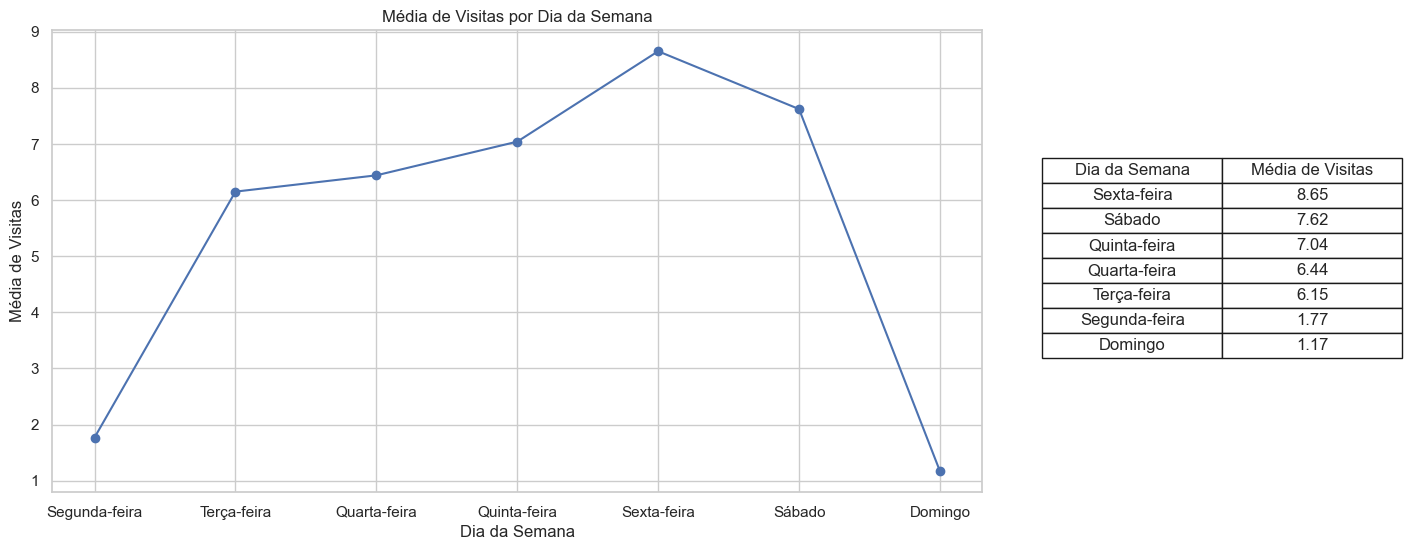

In [10]:
visits_by_week_day = {i: {'num_visits': 0, 'num_days': 0} for i in range(7)}

dates = df['data'].unique()

for date in dates:
    num_visits_date = df[df['data'] == date].shape[0]
    date = pd.Timestamp(date)
    weekday = date.weekday()
    visits_by_week_day[weekday]['num_visits'] += num_visits_date
    visits_by_week_day[weekday]['num_days'] += 1

mean_per_day = {day: round(visits_by_week_day[day]['num_visits'] / visits_by_week_day[day]['num_days'], 2) if visits_by_week_day[day]['num_days'] > 0 else 0 for day in visits_by_week_day}

dias_semana = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
mean_per_day_name = {dias_semana[day]: mean_per_day[day] for day in mean_per_day}

mean_per_day_df = pd.DataFrame(list(mean_per_day_name.items()), columns=['Dia da Semana', 'Média de Visitas'])
mean_per_day_df = mean_per_day_df.sort_values(by='Média de Visitas', ascending=False)

# Plotar a média de visitas por dia da semana
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de linha
ax1.plot(mean_per_day_name.keys(), mean_per_day_name.values(), marker='o')
ax1.set_title('Média de Visitas por Dia da Semana')
ax1.set_xlabel('Dia da Semana')
ax1.set_ylabel('Média de Visitas')

# Adicionar tabela ao lado do gráfico
ax2 = fig.add_axes([1, 0.1, 0.2, 0.8])  # [left, bottom, width, height]
ax2.axis('off')
tbl = ax2.table(cellText=mean_per_day_df.values, colLabels=mean_per_day_df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.5, 1.5)

plt.show()

#### Conclusões

Essas análises destacam padrões temporais importantes no movimento da barbearia, evidenciando a sazonalidade e variações semanais nas visitas. Identificar esses padrões pode ser útil para planejar campanhas de marketing, ajustar horários de funcionamento e melhorar a gestão de recursos.

### Frequência dos clientes

#### Distribuição da Quantidade de Visitas dos Clientes

O primeiro gráfico analisado mostra a distribuição da quantidade de visitas dos clientes. No eixo X temos a quantidade de visitas, e no eixo Y o número de clientes que possuem aquela quantidade de visitas. Observamos que essa distribuição segue uma Power Law, ou seja, há um grande volume de clientes com poucas visitas e um número pequeno de clientes com muitas visitas.

- **Clientes com 1 Visita**: Representam 31,58% dos clientes (318 clientes).
- **Cliente com Mais Visitas**: O cliente com o maior número de visitas tem 327 visitas.
- **Média de Visitas**: A média de visitas é de 13,33, mas é puxada para a direita por um pequeno número de clientes com muitas visitas.
- **Clientes Acima da Média**: Apenas 265 clientes (26,32% do total) têm uma frequência de visitas maior que a média.

O boxplot complementa essa análise, identificando vários outliers e destacando o cliente mais frequente com 327 visitas, quase isolado no gráfico. A média de visitas é visualmente próxima de zero devido ao alto número de clientes com poucas visitas.

C:\Users\fredb\AppData\Local\Temp\ipykernel_16584\3692704723.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajusta o layout para incluir a tabela ao lado


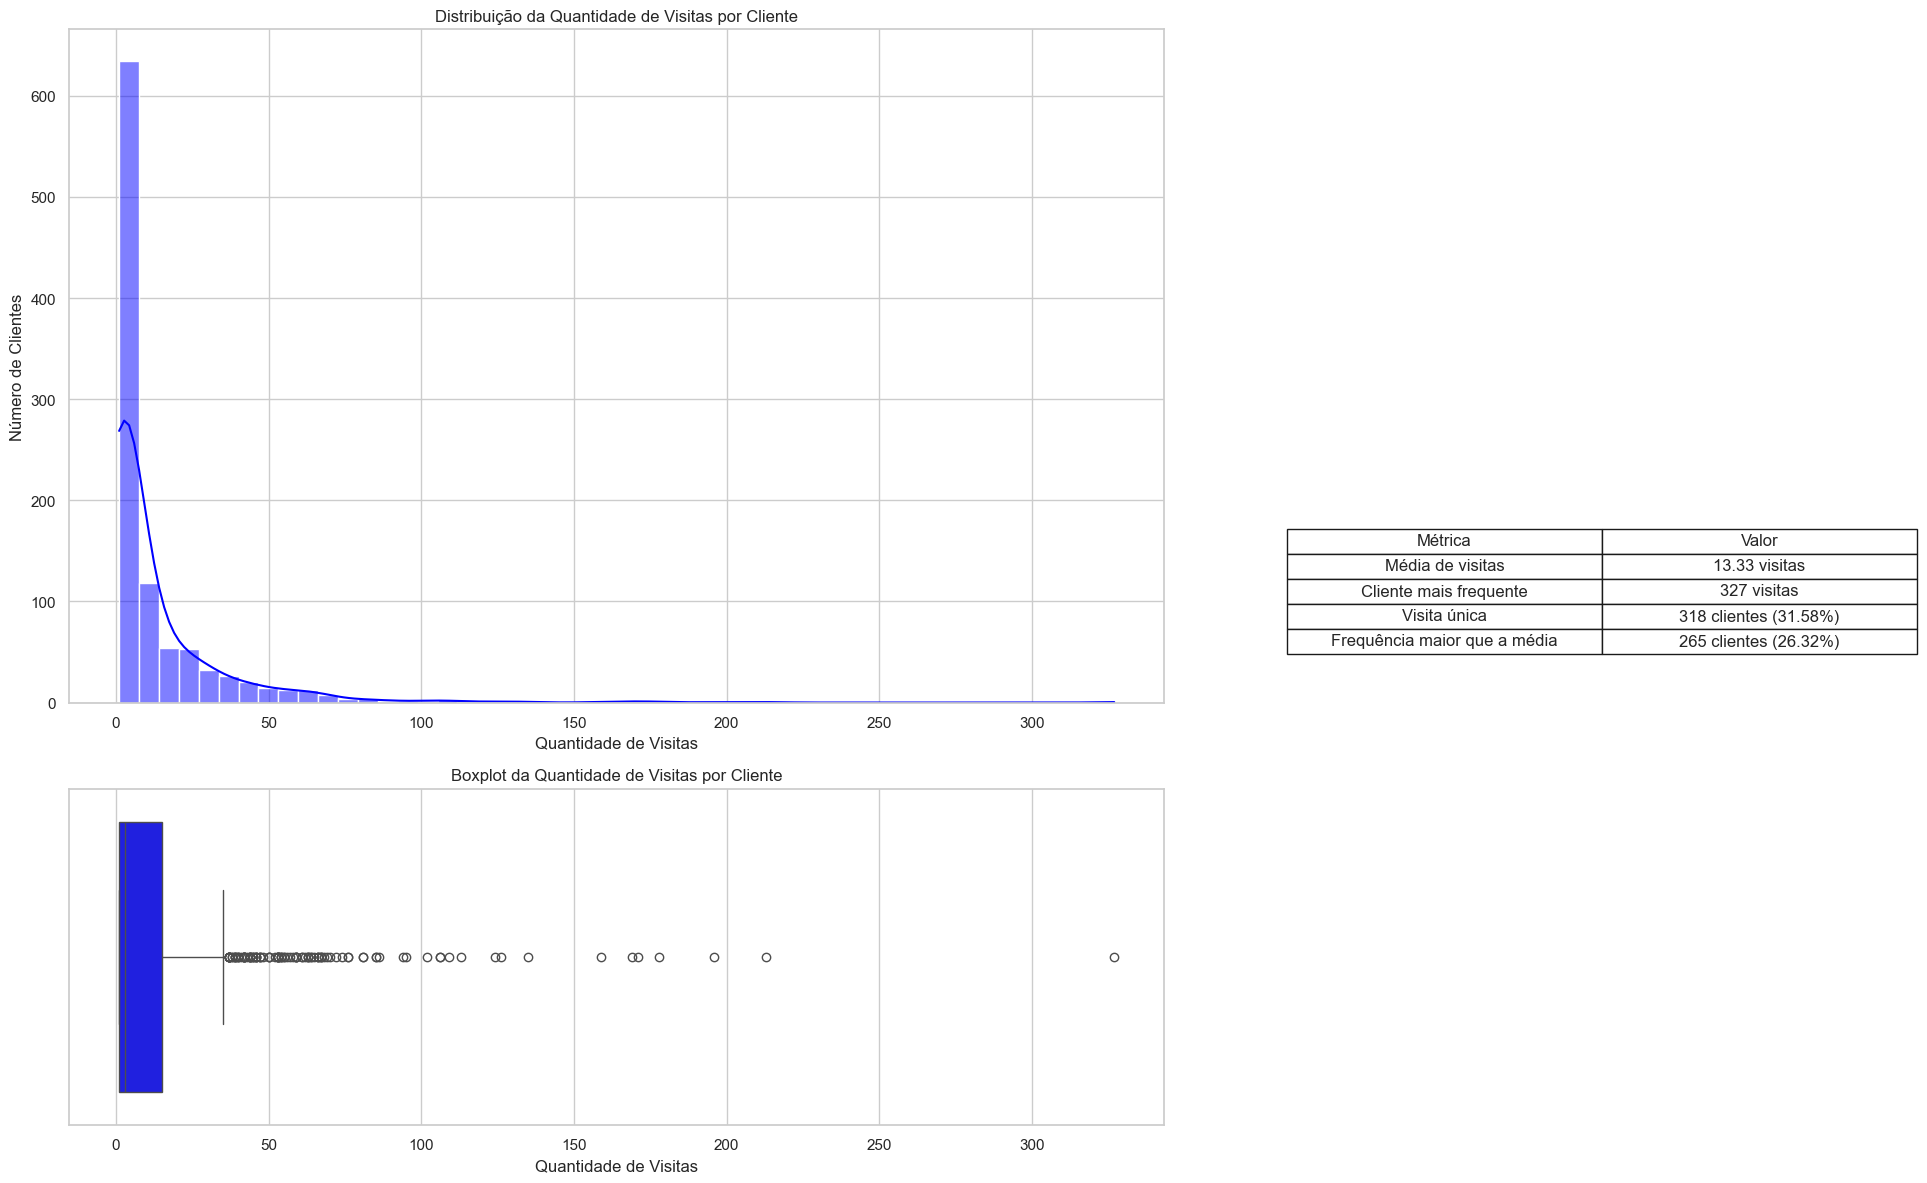

In [59]:
visits_per_client = df.groupby('id').size().reset_index(name='visits')

# Calcula as métricas necessárias
mean_visits = visits_per_client['visits'].mean()
max_visits = visits_per_client['visits'].max()
clients_one_visit = visits_per_client[visits_per_client['visits'] == 1].shape[0]
clients_more_than_mean = visits_per_client[visits_per_client['visits'] > mean_visits].shape[0]
total_clients = visits_per_client.shape[0]

# Calcula as porcentagens
percent_one_visit = (clients_one_visit / total_clients) * 100
percent_more_than_mean = (clients_more_than_mean / total_clients) * 100

# Organiza os dados em uma tabela
table_data = [
    ['Média de visitas', f'{mean_visits:.2f} visitas'],
    ['Cliente mais frequente', f'{max_visits} visitas'],
    ['Visita única', f'{clients_one_visit} clientes ({percent_one_visit:.2f}%)'],
    ['Frequência maior que a média', f'{clients_more_than_mean} clientes ({percent_more_than_mean:.2f}%)']
]

sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1]})

# Histograma
sns.histplot(visits_per_client['visits'], bins=50, kde=True, color='blue', ax=ax1)
ax1.set_title('Distribuição da Quantidade de Visitas por Cliente')
ax1.set_xlabel('Quantidade de Visitas')
ax1.set_ylabel('Número de Clientes')

# Boxplot
sns.boxplot(x=visits_per_client['visits'], ax=ax2, color='blue')
ax2.set_title('Boxplot da Quantidade de Visitas por Cliente')
ax2.set_xlabel('Quantidade de Visitas')

# Adicionar tabela ao lado do gráfico
ax3 = fig.add_axes([1, 0.1, 0.3, 0.8])  # [left, bottom, width, height]
ax3.axis('off')
tbl = ax3.table(cellText=table_data, colLabels=['Métrica', 'Valor'], cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.5, 1.5)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajusta o layout para incluir a tabela ao lado
plt.show()

#### Média de Visitas por Cliente ao Longo dos Anos

O próximo gráfico mostra a média de visitas por cliente ao longo dos anos, com os anos no eixo X e o valor médio de visitas por cliente naquele ano no eixo Y. Este gráfico revela tendências interessantes.

- **Anos de Abertura e Coleta**: 2016 e 2024 são menos relevantes para esta análise, pois 2016 foi o ano de abertura da barbearia e 2024 é o ano de coleta parcial dos dados.
- **Análise de 2017 a 2023**: Observamos um claro aumento na média de visitas por cliente ao longo desses anos, indicando um aumento na fidelidade dos clientes.
- **Pico em 2023**: A média de visitas por cliente atinge seu pico em 2023, com um valor médio de 7,65 visitas por cliente.

Essa análise sugere que, embora o número total de clientes possa ter diminuído, a fidelidade dos clientes aumentou, resultando em um maior número de visitas por cliente ao longo do tempo.

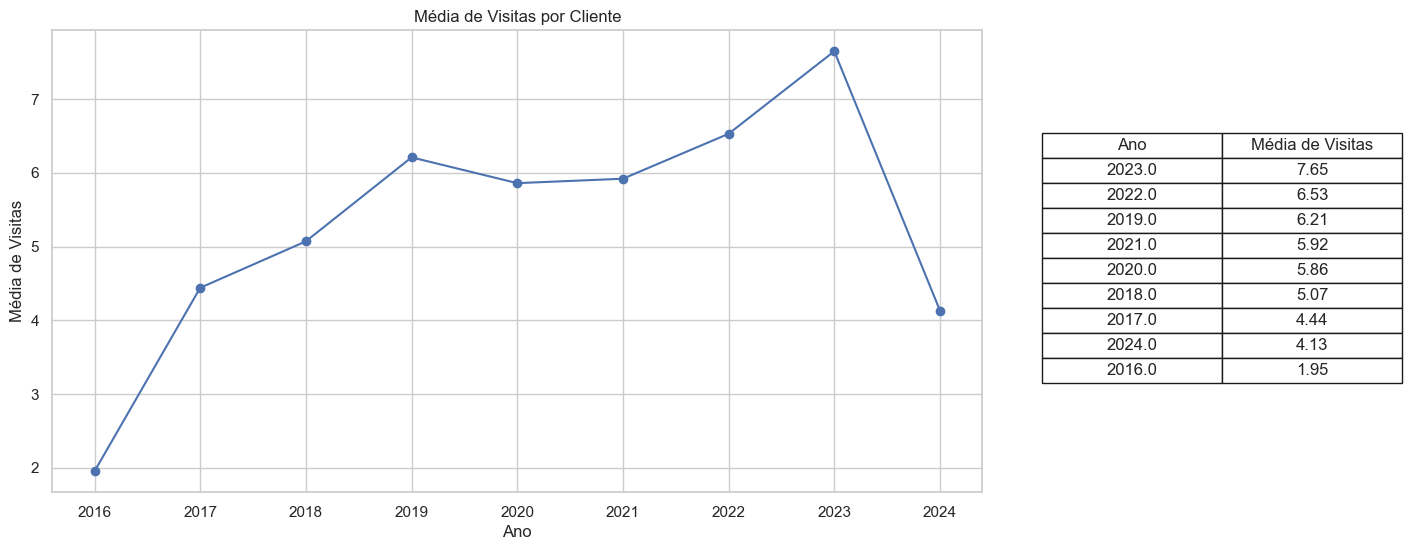

In [44]:
# Média de visitas por cliente por ano

years = np.sort(df['ano'].unique())
clients = df['id'].unique()

frequency_by_year = {year: [] for year in years}

for year in years:
    
    df_year = df[df['ano'] == year]
    for client in clients:
        num_visits = df_year[df_year['id'] == client].shape[0]
        if num_visits > 0: # Only clients that visited at least once are considered
            frequency_by_year[year].append(num_visits)
    frequency_by_year[year] = round(np.mean(frequency_by_year[year]), 2)
    
mean_per_year_df = pd.DataFrame(list(frequency_by_year.items()), columns=['Ano', 'Média de Visitas'])
mean_per_year_df = mean_per_year_df.sort_values(by='Média de Visitas', ascending=False)

# Plotar a média de visitas
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de linha
ax1.plot(frequency_by_year.keys(), frequency_by_year.values(), marker='o')
ax1.set_title('Média de Visitas por Cliente')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Média de Visitas')

# Adicionar tabela ao lado do gráfico
ax2 = fig.add_axes([1, 0.1, 0.2, 0.8])  # [left, bottom, width, height]
ax2.axis('off')
tbl = ax2.table(cellText=mean_per_year_df.values, colLabels=mean_per_year_df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.5, 1.5)

plt.show()

### Intervalo entre visitas

#### Intervalo Médio entre Visitas por Ano

O primeiro gráfico que analisamos mostra o intervalo médio entre as visitas dos clientes, com o ano no eixo X e o intervalo médio em dias no eixo Y. Observamos algumas tendências interessantes:

- *Aumento Progressivo*: Entre 2017 e 2022, há um aumento claro no intervalo médio entre as visitas dos clientes, indicando que os clientes estavam espaçando mais suas visitas ao longo dos anos.
- *Redução em 2023*: Em 2023, há uma redução significativa no intervalo médio entre visitas, sugerindo que os clientes se tornaram mais frequentes. Isso pode indicar uma mudança nos hábitos dos clientes ou uma maior procura por serviços que exigem visitas mais frequentes, como barba e manutenção regular.

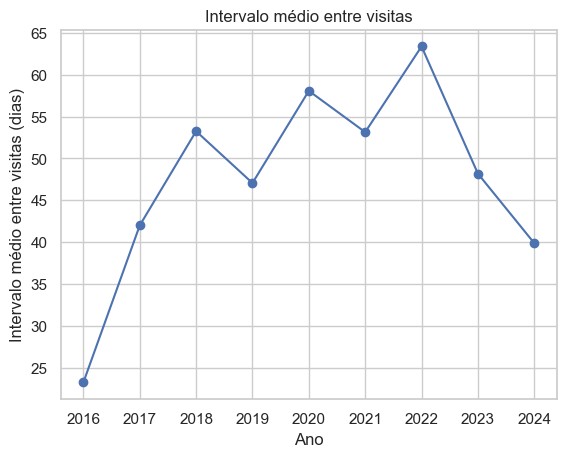

In [53]:
df['data'] = pd.to_datetime(df['data'])
df['visit_diff'] = df.groupby('id')['data'].diff().dt.days
average_intervals = df.groupby('ano')['visit_diff'].mean().reset_index()

average_intervals.columns = ['ano', 'media_intervalo_visita']

plt.plot(average_intervals['ano'], average_intervals['media_intervalo_visita'], marker='o')
plt.title('Intervalo médio entre visitas')
plt.xlabel('Ano')
plt.ylabel('Intervalo médio entre visitas (dias)')
plt.show()

#### Intervalo de Visitas para Clientes Novos e Antigos

O segundo gráfico analisa o intervalo médio entre visitas, separando os clientes em novos e antigos. Clientes novos são definidos como aqueles cuja primeira visita ocorreu no ano em análise, enquanto clientes antigos são aqueles cuja primeira visita foi em anos anteriores. As tendências observadas são:

- *Clientes Novos vs. Clientes Antigos*: Clientes antigos têm um intervalo médio maior entre visitas comparado aos clientes novos. Inicialmente, pode parecer que clientes novos visitam a barbearia com mais frequência, mas há um fator importante a considerar.
- *Impacto dos Intervalos Grandes*: Clientes antigos incluem aqueles que podem ter interrompido suas visitas por um período significativo e eventualmente retornaram. Por exemplo, um cliente que visitou a barbearia em 2016 e voltou apenas em 2023 pode ter um intervalo muito grande entre as visitas, o que puxa a média para cima.
- *Média vs. Mediana*: Esse comportamento evidencia uma limitação da média como métrica. A média pode ser influenciada por outliers, enquanto a mediana poderia fornecer uma visão mais representativa do comportamento típico dos clientes.

Essas observações destacam a importância de considerar diferentes métricas ao analisar dados de intervalo entre visitas. A mediana, por exemplo, poderia fornecer uma visão mais robusta ao minimizar o impacto de intervalos excepcionalmente grandes.

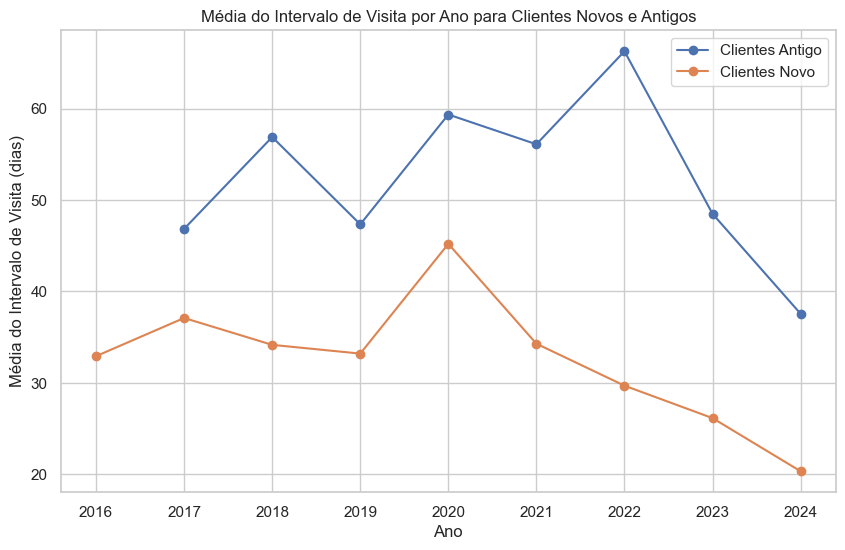

In [59]:
df['data'] = pd.to_datetime(df['data'])
df['primeira_visita'] = pd.to_datetime(df['primeira_visita'])

df = df.sort_values(by=['id', 'data'])

df['visit_diff'] = df.groupby('id')['data'].diff().dt.days

df['ano'] = df['data'].dt.year
df['cliente_tipo'] = np.where(df['primeira_visita'].dt.year == df['ano'], 'Novo', 'Antigo')

average_intervals = df.groupby(['ano', 'cliente_tipo'])['visit_diff'].mean().reset_index()
average_intervals.columns = ['ano', 'cliente_tipo', 'media_intervalo_visita']

plt.figure(figsize=(10, 6))

for tipo in average_intervals['cliente_tipo'].unique():
    subset = average_intervals[average_intervals['cliente_tipo'] == tipo]
    plt.plot(subset['ano'], subset['media_intervalo_visita'], marker='o', label=f'Clientes {tipo}')

plt.xlabel('Ano')
plt.ylabel('Média do Intervalo de Visita (dias)')
plt.title('Média do Intervalo de Visita por Ano para Clientes Novos e Antigos')
plt.legend()
plt.grid(True)
plt.show()

#### Mediana do Intervalo entre Visitas por Ano

Ao analisar o gráfico da mediana do intervalo entre visitas, observamos um comportamento diferente em relação ao gráfico da média. A mediana divide a distribuição em duas partes iguais, fornecendo um valor central que é menos influenciado por outliers.

- *Proximidade Entre Clientes Novos e Antigos*: A mediana do intervalo de visita para clientes novos e antigos é bem próxima na maioria dos anos, com uma diferença pequena, geralmente em torno de 5 dias.
- *Distanciamento a Partir de 2021*: A partir de 2021, há um distanciamento significativo entre as medianas, que se acentua em 2023.
- *Indicadores de Campanhas e Serviços Frequentes*: Em 2023, a mediana dos clientes novos é inferior a 17,5 dias, sugerindo uma frequência de visitas próxima de duas vezes por mês. Isso pode indicar campanhas específicas ou uma maior procura por serviços que requerem visitas mais frequentes, como manutenção de barba.

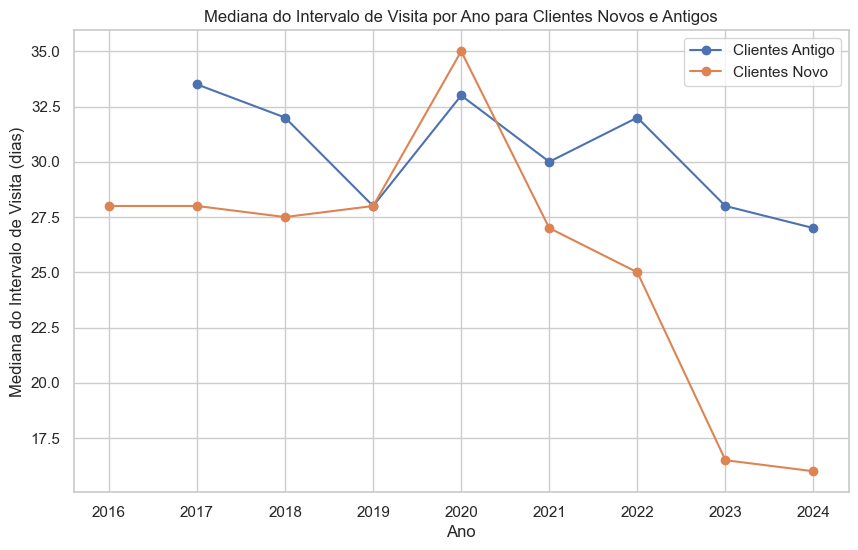

In [60]:
df['data'] = pd.to_datetime(df['data'])
df['primeira_visita'] = pd.to_datetime(df['primeira_visita'])

df = df.sort_values(by=['id', 'data'])

df['visit_diff'] = df.groupby('id')['data'].diff().dt.days

df['ano'] = df['data'].dt.year
df['cliente_tipo'] = np.where(df['primeira_visita'].dt.year == df['ano'], 'Novo', 'Antigo')

average_intervals = df.groupby(['ano', 'cliente_tipo'])['visit_diff'].median().reset_index()
average_intervals.columns = ['ano', 'cliente_tipo', 'mediana_intervalo_visita']

plt.figure(figsize=(10, 6))

for tipo in average_intervals['cliente_tipo'].unique():
    subset = average_intervals[average_intervals['cliente_tipo'] == tipo]
    plt.plot(subset['ano'], subset['mediana_intervalo_visita'], marker='o', label=f'Clientes {tipo}')

plt.xlabel('Ano')
plt.ylabel('Mediana do Intervalo de Visita (dias)')
plt.title('Mediana do Intervalo de Visita por Ano para Clientes Novos e Antigos')
plt.legend()
plt.grid(True)
plt.show()

### Número de novos clientes

#### Número de Novos Clientes por Ano

O primeiro gráfico analisado mostra o número de novos clientes por ano, revelando um padrão claro e preocupante ao longo do tempo:

- *Queda Significativa*: O número de novos clientes caiu drasticamente, de cerca de 350 em 2016, ano de abertura da barbearia, para apenas 25 novos clientes em 2023.
- *Implicações*: Apesar dessa queda acentuada no número de novos clientes, o número total de visitas não diminuiu de forma tão drástica, como observado nas análises anteriores.

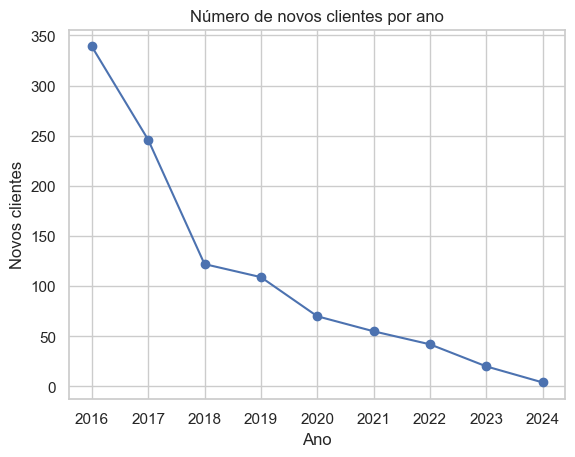

In [47]:
years = np.sort(df['ano'].unique())

new_clients_by_year = []

for year in years:
    df['primeira_visita'] = pd.to_datetime(df['primeira_visita'])
    df_first_visit_year = df[df['primeira_visita'].dt.year == year]
    new_clients = df_first_visit_year.drop_duplicates(subset=['primeira_visita', 'id']).shape[0]
    new_clients_by_year.append(new_clients)

plt.plot(years, new_clients_by_year, marker='o')
plt.title('Número de novos clientes por ano')
plt.xlabel('Ano')
plt.ylabel('Novos clientes')
plt.show()

#### Número de Clientes Atendidos por Ano

O próximo gráfico analisa o número de clientes atendidos por ano, mostrando um padrão de queda mais suave:

- *Padrão de Queda*: O número de clientes atendidos aumentou de cerca de 350 em 2016 para próximo de 400 em 2017, seguido por uma queda gradual nos anos subsequentes.
- *Retenção de Clientes*: Em 2023, o número de clientes atendidos é de cerca de 200, indicando que a barbearia conseguiu reter muitos dos clientes ao longo dos anos.
- *Frequência de Visitas*: A frequência de visitas aumentou ao longo do tempo, o que é positivo para a barbearia, pois é mais eficiente reter clientes existentes do que adquirir novos.

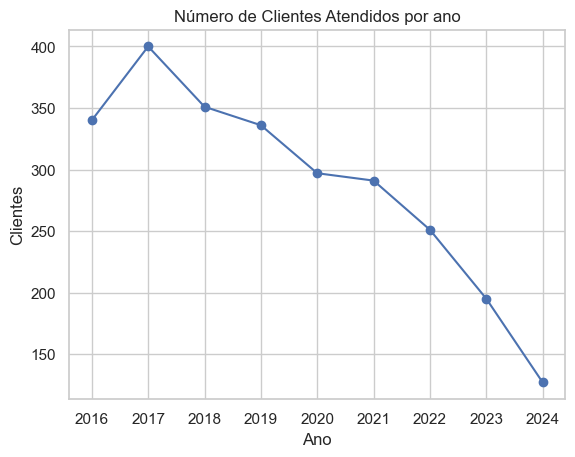

In [46]:
years = np.sort(df['ano'].unique())

clients_by_year = []

for year in years:
    df_year = df[df['ano'] == year]
    num_clients = df_year['id'].unique().shape[0]
    clients_by_year.append(num_clients)

plt.plot(years, clients_by_year, marker='o')
plt.title('Número de Clientes Atendidos por ano')
plt.xlabel('Ano')
plt.ylabel('Clientes')
plt.show()

#### Origem do Volume de Visitas: Clientes Novos vs. Clientes Antigos

Para entender melhor o volume de visitas, analisamos a contribuição de clientes novos e antigos:

- *Histograma de Contribuição*: O histograma mostra a porcentagem de visitas de clientes novos e antigos ao longo dos anos.
- *Clientes Antigos*: A contribuição dos clientes antigos aumentou de 50% em 2017 para mais de 90% em 2023. Isso indica que a maior parte das visitas vem de clientes antigos, evidenciando a importância da retenção de clientes para a barbearia.

<function matplotlib.pyplot.show(close=None, block=None)>

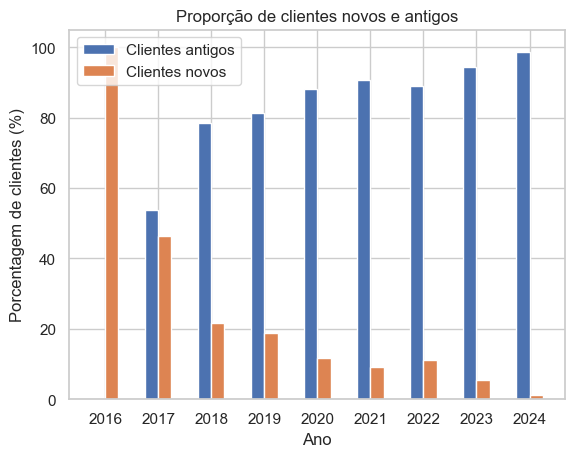

In [42]:
years = np.sort(df['ano'].unique())

data = {
    'year': years,
    'oldClients': [],
    'newClients': [],
}
for year in years:
    visits_old_clients = 0
    visits_new_clients = 0
    
    df_year = df[df['ano'] == year]
    for _, row in df_year.iterrows():
        if pd.to_datetime(row['primeira_visita']) < pd.to_datetime(f'01-01-{year}'):
            visits_old_clients += 1
        else:
            visits_new_clients += 1
    
    total_visits = visits_old_clients + visits_new_clients
    fraction_old_clients = visits_old_clients / total_visits
    fraction_new_clients = visits_new_clients / total_visits
    
    data['oldClients'].append(round(fraction_old_clients * 100, 2))
    data['newClients'].append(round(fraction_new_clients * 100, 2))

data_df = pd.DataFrame(data)

num_years = np.arange(len(data_df['year']))

fig, ax = plt.subplots()
bar_width = 0.25

bars_old_clients = ax.bar(num_years - bar_width/2, data_df['oldClients'], bar_width, label = 'Clientes antigos')
bars_old_clients = ax.bar(num_years + bar_width/2, data_df['newClients'], bar_width, label = 'Clientes novos')

ax.set_xlabel('Ano')
ax.set_ylabel('Porcentagem de clientes (%)')
ax.set_title('Proporção de clientes novos e antigos')
ax.set_xticks(num_years)
ax.set_xticklabels(data_df['year'])
ax.legend()

plt.show

### Retenção e Churn

#### Análise da Taxa de Churn por Ano

O último gráfico analisado mostra a taxa de churn por ano, fornecendo insights sobre a retenção de clientes ao longo do tempo:

- *Taxa de Churn Baixa*: A taxa de churn permaneceu consistentemente baixa, sempre abaixo de 10% ao ano.
- *Anos com Churn Ainda Menor*: Em alguns anos, como 2019 e 2023, a taxa de churn foi ainda menor, caindo abaixo de 7%. 
- *Capacidade de Retenção*: Esses valores baixos de churn destacam a habilidade da barbearia em manter seus clientes ao longo do tempo, um fator crucial para a manutenção do volume de clientes.

#### Implicações

A baixa taxa de churn, com uma média de 7,29%, reforça a eficiência da barbearia em fidelizar seus clientes. Essa capacidade de retenção é essencial para a estabilidade e crescimento do negócio, garantindo um fluxo constante de clientes e reduzindo a necessidade de investir pesadamente em adquirir novos clientes.

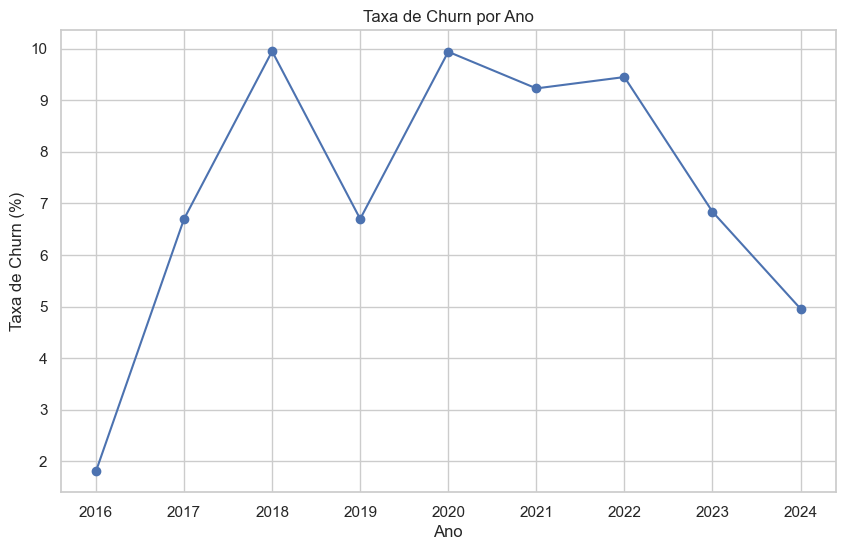

Taxa média de churn: 7.29%


In [69]:
df['data'] = pd.to_datetime(df['data'])
df['primeira_visita'] = pd.to_datetime(df['primeira_visita'])

df = df.sort_values(by=['id', 'data'])

df['visit_diff'] = df.groupby('id')['data'].diff().dt.days

df['ano'] = df['data'].dt.year
df['cliente_tipo'] = np.where(df['primeira_visita'].dt.year == df['ano'], 'Novo', 'Antigo')

df['churn'] = np.where(df['visit_diff'] > 90, 1, 0)

churn_rate = df.groupby(['ano'])['churn'].mean().reset_index()
churn_rate.columns = ['ano', 'taxa_churn']

churn_rate['taxa_churn'] = round(churn_rate['taxa_churn'] * 100, 2)

plt.figure(figsize=(10, 6))

plt.plot(churn_rate['ano'], churn_rate['taxa_churn'], marker='o')
plt.xlabel('Ano')
plt.ylabel('Taxa de Churn (%)')
plt.title('Taxa de Churn por Ano')
plt.grid(True)
plt.show()
mean_churn = round(np.mean(churn_rate['taxa_churn']), 2)
print(f'Taxa média de churn: {mean_churn}%')

## Previsão de Recorrência de Clientes

Prever a recorrência dos clientes e antecipar quando eles retornarão é essencial para qualquer negócio, especialmente para aqueles como uma barbearia, onde não há garantias sobre a frequência de retorno dos clientes. Este é um dado crucial para direcionar campanhas de marketing, enviando ofertas personalizadas para clientes que provavelmente demorarão a voltar, incentivando-os a se tornarem mais frequentes. Além disso, prever a recorrência dos clientes proporciona previsibilidade de receita ao longo dos meses, permitindo um melhor planejamento financeiro e operacional.

Para atingir esse objetivo, modelaremos o dataset como uma série temporal, buscando prever a próxima data em que um cliente visitará a barbearia, com base em uma janela das suas últimas seis visitas. Inicialmente, calcularemos o número de dias que levou para um cliente retornar à barbearia desde sua primeira visita e usaremos uma LSTM (Long Short-Term Memory) para tentar capturar esses padrões temporais nos dados.

As LSTMs são um tipo de rede neural recorrente (RNN) especialmente projetada para aprender dependências de longo prazo em séries temporais. Elas são capazes de reter informações importantes por longos períodos, atribuindo pesos maiores às observações recentes e pesos menores às observações mais antigas. Isso é feito através de sua arquitetura única de células de memória que controlam o fluxo de informações, permitindo que a rede memorize ou esqueça informações de forma seletiva. Essa capacidade torna as LSTMs particularmente eficazes para a previsão de séries temporais, onde padrões e tendências devem ser identificados ao longo do tempo.

In [125]:
df = pd.read_csv('presenca_clientes_limpo.csv')

df['data'] = pd.to_datetime(df['data'])
df['primeira_visita'] = pd.to_datetime(df['primeira_visita'])

df['days_since_first_visit'] = (df['data'] - df['primeira_visita']).dt.days

df['year'] = df['data'].dt.year
df['month'] = df['data'].dt.month

df.head()

,id,data,primeira_visita,days_since_first_visit,year,month
0,1,2016-07-28,2016-07-28,0,2016,7
1,1,2016-10-27,2016-07-28,91,2016,10
2,1,2016-12-20,2016-07-28,145,2016,12
3,1,2017-03-03,2016-07-28,218,2017,3
4,1,2017-04-26,2016-07-28,272,2017,4


É crucial ter cuidado ao separar dados de séries temporais entre conjuntos de treino, validação e teste, para garantir que o modelo seja treinado de forma eficaz e avaliado corretamente. Para esse fim, usaremos a seguinte abordagem:

- **Treino**: 80% dos clientes até 2023
- **Validação**: 20% dos clientes até 2023
- **Teste**: Dados de todos os clientes a partir de 2023

Essa divisão é escolhida para preservar a integridade dos dados temporais e capturar padrões sazonais. Se usássemos dados de apenas um período para treino, poderíamos perder importantes aspectos sazonais, dificultando a generalização do modelo. Ao incluir dados de diferentes períodos no conjunto de treino, garantimos que o modelo tenha acesso a uma variedade de padrões sazonais e comportamentais, melhorando sua capacidade de generalizar para novos dados.

Além disso, usar dados posteriores a 2023 para o conjunto de teste evita o vazamento de informações, simulando um cenário real em que o modelo é utilizado para prever eventos futuros ainda não vistos. Essa abordagem permite avaliar o desempenho do modelo de forma realista, garantindo que ele seja robusto e confiável quando aplicado a novos dados no futuro.

In [126]:
def split_data(df):
    df_test = df[df['year'] >= 2023]
    df_until_2022 = df[df['year'] < 2023]

    customer_ids = df_until_2022['id'].unique()
    np.random.seed(42)
    np.random.shuffle(customer_ids)

    train_size = int(len(customer_ids) * 0.8)
    train_customers = customer_ids[:train_size]
    val_customers = customer_ids[train_size:]

    df_train = df_until_2022[df_until_2022['id'].isin(train_customers)]
    df_val = df_until_2022[df_until_2022['id'].isin(val_customers)]

    return df_train, df_val, df_test

#### Preparação das Sequências para LSTM

A primeira etapa no uso de LSTMs para prever a recorrência dos clientes envolve a criação das sequências que serão usadas como entrada no modelo. Cada sequência representa o número de dias entre as visitas de um cliente, começando desde a primeira visita. Por exemplo, se a segunda visita ocorreu um mês após a primeira, o valor será 30, e se a terceira visita ocorreu dois meses após a primeira, o valor será 60, e assim por diante.

Essa função create_sequences percorre o dataframe dos dados, agrupando-os por cliente, e cria sequências de tamanho fixo (window_size) que serão usadas para treinar o modelo LSTM.


In [127]:
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for customer_id, group in data.groupby('id'):
        for i in range(len(group) - window_size):
            seq = group['days_since_first_visit'].iloc[i:i + window_size].values
            target = group['days_since_first_visit'].iloc[i + window_size]
            sequences.append(seq)
            targets.append(target)
    return np.array(sequences), np.array(targets)


#### Definição e Treinamento do Modelo LSTM

A próxima etapa é definir e treinar o modelo LSTM. Começamos com um modelo simples, que inclui uma única camada LSTM seguida de uma camada densa para fazer a regressão e prever a próxima visita do cliente.

Este modelo LSTM é configurado com 50 unidades na camada LSTM e usa a função de ativação relu. Após a camada LSTM, uma camada densa é adicionada para realizar a previsão de regressão.

In [128]:
def train_model(X_train, y_train, X_val, y_val, window_size, epochs=100):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=1)
    return model, history

In [129]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Loss de Treinamento')
    plt.plot(history.history['val_loss'], label='Loss de Validação')
    plt.title('Gráfico de Perda (Loss) - Treinamento e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [130]:
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R-squared: {r2}')
    return y_pred

In [131]:
df_train, df_val, df_test = split_data(df)
print(f"Train: {df_train.shape}")
print(f"Val: {df_val.shape}")
print(f"Test: {df_test.shape}")

window_size = 6
X_train, y_train = create_sequences(df_train, window_size)
X_val, y_val = create_sequences(df_val, window_size)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

model, history = train_model(X_train, y_train, X_val, y_val, window_size, epochs=100)

Train: (9352, 6)
Val: (2059, 6)
Test: (2016, 6)
Epoch 1/100


c:\Users\fredb\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 565451.4375 - val_loss: 13508.1982
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11675.9941 - val_loss: 19649.0508
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 16272.2188 - val_loss: 12821.2793
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8526.5137 - val_loss: 11771.7324
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9029.3350 - val_loss: 10899.8906
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7945.7817 - val_loss: 17116.8887
Epoch 7/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9752.0977 - val_loss: 11514.0576
Epoch 8/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9261.9199 - val_loss: 11485.4385
Epoch 9/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10901.8184 - val_loss: 10302.2148
Epoch 10/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7568.5776 - val_loss: 10242.3682
Epoch 11/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7809

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Squared Error: 8447.18664516348
Mean Absolute Error: 37.665002381654645
Root Mean Squared Error: 91.90857764737457
R-squared: 0.9710355401039124
Comparação de previsões para algumas instâncias de validação:
Instância 1:
Sequência de Entrada: [ 0  7 13 35 49 57]
Valor Real: 82
Previsão: [109.85592]

Instância 2:
Sequência de Entrada: [ 7 13 35 49 57 82]
Valor Real: 92
Previsão: [108.88553]

Instância 3:
Sequência de Entrada: [13 35 49 57 82 92]
Valor Real: 145
Previsão: [111.43853]

Instância 4:
Sequência de Entrada: [ 35  49  57  82  92 145]
Valor Real: 152
Previsão: [174.67824]

Instância 5:
Sequência de Entrada: [ 49  57  82  92 145 152]
Valor Real: 169
Previsão: [189.08861]



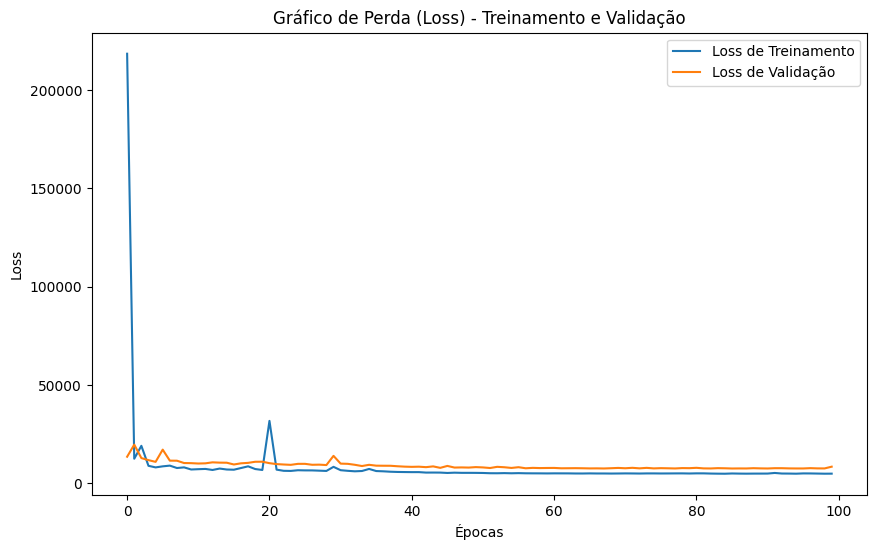

In [132]:
y_pred = evaluate_model(model, X_val, y_val)

num_instances_to_show = 5
print("Comparação de previsões para algumas instâncias de validação:")
for i in range(num_instances_to_show):
    print(f"Instância {i+1}:")
    print(f"Sequência de Entrada: {X_val[i].flatten()}")
    print(f"Valor Real: {y_val[i]}")
    print(f"Previsão: {y_pred[i]}\n")

plot_loss(history)

Os resultados da primeira LSTM não foram tão positivos quanto esperávamos. Ao analisar o gráfico da perda (loss), observamos que inicialmente a perda diminui de forma significativa, partindo de um valor bastante alto. No entanto, após poucas épocas, a perda se estabiliza em torno de 5.000 a 7.000 e não diminui significativamente após isso.

#### Análise Qualitativa

Quando comparamos qualitativamente os valores reais e as previsões, percebemos que o modelo consegue prever valores razoavelmente próximos dos reais, mas ainda com certa divergência. É importante notar que prever exatamente o dia em que um cliente voltará é um desafio complexo, com várias incertezas inerentes ao problema.

#### Avaliação do Modelo com Janela de Tolerância

Para uma avaliação mais relaxada do modelo, implementamos uma função que considera uma janela de tolerância de 7 dias antes e 7 dias depois da data prevista pelo modelo. Se o modelo prever uma data dentro dessa janela, consideramos que ele acertou; caso contrário, ele errou. Dessa forma, calculamos a acurácia do modelo.

In [133]:
def evaluate_model_with_window(model, X_val, y_val, window_size=7):
    y_pred = model.predict(X_val)
    
    correct_predictions = 0
    total_predictions = len(y_val)
    
    for i in range(total_predictions):
        if y_val[i] - window_size <= y_pred[i] <= y_val[i] + window_size:
            correct_predictions += 1
    
    accuracy = correct_predictions / total_predictions
    print(f'Acurácia dentro da janela de {window_size} dias: {accuracy * 100:.2f}%')
    
    return accuracy

In [134]:
evaluate_model_with_window(model, X_val, y_val, window_size=7)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acurácia dentro da janela de 7 dias: 19.72%


0.19724437998549674

#### Resultado da Acurácia

A acurácia calculada com essa janela de tolerância foi de 0,47, indicando que o modelo acertou em 47% das previsões. Esse resultado é razoável mas ainda não é muito positivo, sugerindo que a abordagem inicial pode não ser suficiente para capturar os padrões necessários.

#### Ajuste do Modelo

Uma possível melhoria é aumentar o número de visitas consideradas na sequência de entrada para a LSTM. Inicialmente, usamos as 6 últimas visitas, mas vamos aumentar esse valor para considerar as últimas 12 visitas, na tentativa de fornecer mais contexto temporal ao modelo.

In [135]:
df_train, df_val, df_test = split_data(df)
print(f"Train: {df_train.shape}")
print(f"Val: {df_val.shape}")
print(f"Test: {df_test.shape}")

window_size = 12
X_train, y_train = create_sequences(df_train, window_size)
X_val, y_val = create_sequences(df_val, window_size)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

model, history = train_model(X_train, y_train, X_val, y_val, window_size, epochs=100)

Train: (9352, 6)
Val: (2059, 6)
Test: (2016, 6)
Epoch 1/100


c:\Users\fredb\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 115522.6797 - val_loss: 71420.0938
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 59541.6172 - val_loss: 30640.2090
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 44465.4102 - val_loss: 216206.0469
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 25687.5156 - val_loss: 1181542.3750
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 16417.5449 - val_loss: 842549.8750
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11228.3750 - val_loss: 266795.8125
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11759.8525 - val_loss: 275858.3750
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7625.5093 - val_loss: 324451.0938
Epoch 9/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10030.9404 - val_loss: 9151.7041
Epoch 10/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8742.9873 - val_loss: 8190.0542
Epoch 11/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - l

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean Squared Error: 21800.458059435452
Mean Absolute Error: 29.263785827991573
Root Mean Squared Error: 147.64978177916637
R-squared: 0.9179103374481201
Comparação de previsões para algumas instâncias de validação:
Instância 1:
Sequência de Entrada: [  0   7  13  35  49  57  82  92 145 152 169 196]
Valor Real: 222
Previsão: [212.36383]

Instância 2:
Sequência de Entrada: [  7  13  35  49  57  82  92 145 152 169 196 222]
Valor Real: 252
Previsão: [242.58644]

Instância 3:
Sequência de Entrada: [ 13  35  49  57  82  92 145 152 169 196 222 252]
Valor Real: 302
Previsão: [273.99652]

Instância 4:
Sequência de Entrada: [ 35  49  57  82  92 145 152 169 196 222 252 302]
Valor Real: 341
Previsão: [322.10492]

Instância 5:
Sequência de Entrada: [ 49  57  82  92 145 152 169 196 222 252 302 341]
Valor Real: 363
Previsão: [367.69574]



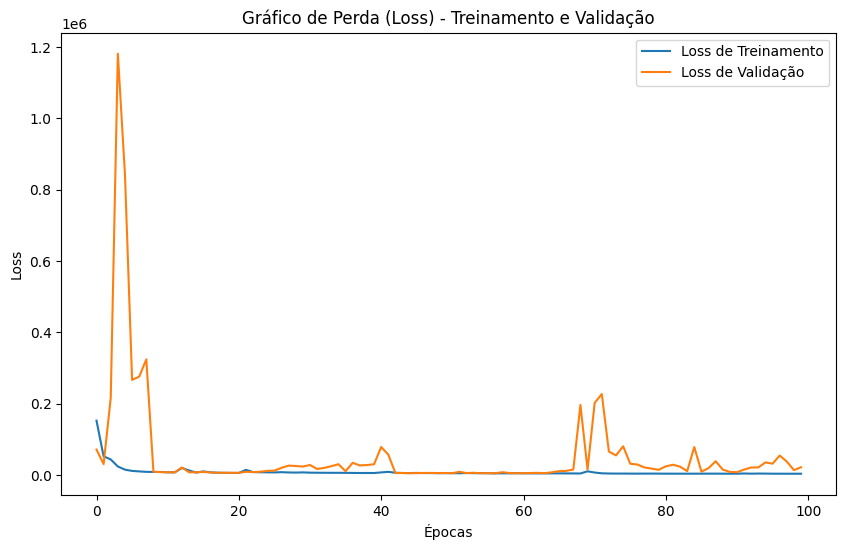

In [136]:
y_pred = evaluate_model(model, X_val, y_val)

# Comparação visual de algumas instâncias de validação
num_instances_to_show = 5
print("Comparação de previsões para algumas instâncias de validação:")
for i in range(num_instances_to_show):
    print(f"Instância {i+1}:")
    print(f"Sequência de Entrada: {X_val[i].flatten()}")
    print(f"Valor Real: {y_val[i]}")
    print(f"Previsão: {y_pred[i]}\n")

plot_loss(history)

In [137]:
evaluate_model_with_window(model, X_val, y_val, window_size=7)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acurácia dentro da janela de 7 dias: 27.81%


0.27810077519379844

#### Ajuste do Modelo LSTM: Avaliação com 12 Instâncias

Curiosamente, ao aumentar o número de instâncias de 6 para 12, o modelo não apresentou uma melhora significativa. A avaliação qualitativa das previsões foi similar ao modelo anterior. No entanto, a acurácia, quando medida com a janela de tolerância de 7 dias, foi consideravelmente pior, resultando em apenas 14%. Esse resultado sugere que o modelo pode ter overfitado nos dados de treino, não conseguindo generalizar tão bem quanto o modelo anterior.

#### Próximo Passo: LSTM Mais Profunda

Para tentar melhorar o desempenho do modelo, a próxima etapa é criar uma LSTM mais profunda, com duas camadas LSTM, mantendo a sequência de 12 últimas visitas. A ideia é verificar se uma arquitetura mais complexa pode capturar melhor os padrões nos dados e melhorar a acurácia.

In [101]:
def train_model(X_train, y_train, X_val, y_val, window_size, epochs=100):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(window_size, 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=1)
    return model, history

In [102]:
df_train, df_val, df_test = split_data(df)
print(f"Train: {df_train.shape}")
print(f"Val: {df_val.shape}")
print(f"Test: {df_test.shape}")

window_size = 12
X_train, y_train = create_sequences(df_train, window_size)
X_val, y_val = create_sequences(df_val, window_size)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

model, history = train_model(X_train, y_train, X_val, y_val, window_size, epochs=100)

Train: (9352, 6)
Val: (2059, 6)
Test: (2016, 6)
Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 424145.0312 - val_loss: 42661.0078
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 26464.6543 - val_loss: 13590.0449
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 25261.8379 - val_loss: 12374.2510
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 14987.5625 - val_loss: 11193.6172
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10882.5449 - val_loss: 14763.4902
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10813.1650 - val_loss: 12627.0791
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 13440.8721 - val_loss: 14286.7598
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15170.4639 - val_loss: 13822.7441
Epoch 9/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 13435.6240 - val_loss: 11396.6553
Epoch 10/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 12402.3799 - val_loss: 23444.7715

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Mean Squared Error: 3647.3529011243595
Mean Absolute Error: 23.772978627404502
Root Mean Squared Error: 60.39331834834346
R-squared: 0.9862658977508545
Comparação de previsões para algumas instâncias de validação:
Instância 1:
Sequência de Entrada: [  0   7  13  35  49  57  82  92 145 152 169 196]
Valor Real: 222
Previsão: [239.25972]

Instância 2:
Sequência de Entrada: [  7  13  35  49  57  82  92 145 152 169 196 222]
Valor Real: 252
Previsão: [274.3413]

Instância 3:
Sequência de Entrada: [ 13  35  49  57  82  92 145 152 169 196 222 252]
Valor Real: 302
Previsão: [299.05234]

Instância 4:
Sequência de Entrada: [ 35  49  57  82  92 145 152 169 196 222 252 302]
Valor Real: 341
Previsão: [329.6978]

Instância 5:
Sequência de Entrada: [ 49  57  82  92 145 152 169 196 222 252 302 341]
Valor Real: 363
Previsão: [372.51755]



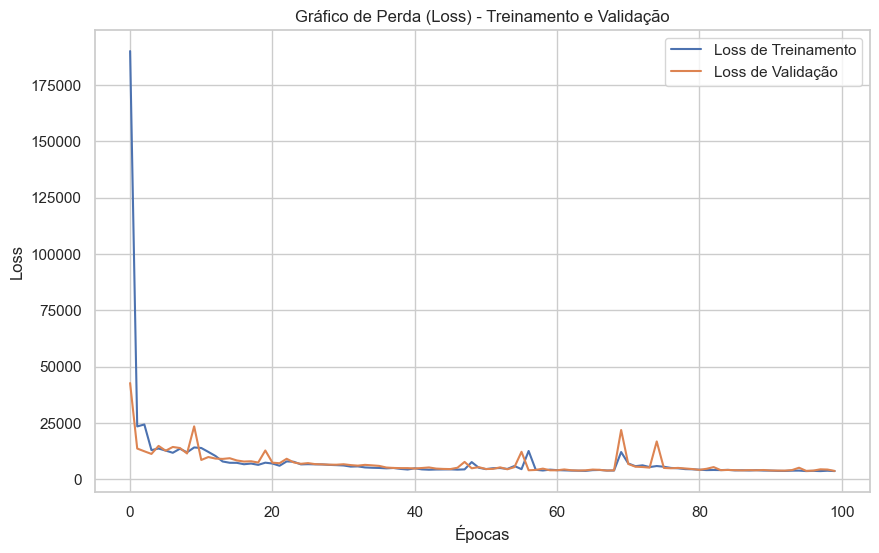

In [103]:
y_pred = evaluate_model(model, X_val, y_val)

num_instances_to_show = 5
print("Comparação de previsões para algumas instâncias de validação:")
for i in range(num_instances_to_show):
    print(f"Instância {i+1}:")
    print(f"Sequência de Entrada: {X_val[i].flatten()}")
    print(f"Valor Real: {y_val[i]}")
    print(f"Previsão: {y_pred[i]}\n")

plot_loss(history)

In [104]:
evaluate_model_with_window(model, X_val, y_val, window_size=7)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Acurácia dentro da janela de 7 dias: 35.27%


0.35271317829457366

In [105]:
def train_cnn_lstm_model(X_train, y_train, X_val, y_val, window_size, epochs=100):
    n_features = 3 
    n_steps = window_size

    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', learning_rate=0.0001)
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=1)
    
    return model, history

In [106]:
df_train, df_val, df_test = split_data(df)
print(f"Train: {df_train.shape}")
print(f"Val: {df_val.shape}")
print(f"Test: {df_test.shape}")

window_size = 12
X_train, y_train = create_sequences(df_train, window_size)
X_val, y_val = create_sequences(df_val, window_size)

# Não aplicar normalização nos dados
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

model, history = train_model(X_train, y_train, X_val, y_val, window_size, epochs=100)

Train: (9352, 6)
Val: (2059, 6)
Test: (2016, 6)
Epoch 1/100


c:\Users\fredb\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1166583.3750 - val_loss: 53857.1992
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 108250.6562 - val_loss: 426407.1250
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 415950.6250 - val_loss: 99774.2109
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 440231.3750 - val_loss: 194341.3750
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 66213.0781 - val_loss: 44495.2188
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 30286.7285 - val_loss: 27496.1035
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 33970.4102 - val_loss: 22586.4238
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 17626.9629 - val_loss: 21090.1367
Epoch 9/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 20207.3965 - val_loss: 16838.7559
Epoch 10/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 15747.2656 - val_loss: 31440.1113
Epoch 11/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Mean Squared Error: 5568.971487607476
Mean Absolute Error: 43.35816213326861
Root Mean Squared Error: 74.62554179104816
R-squared: 0.9790300130844116
Comparação de previsões para algumas instâncias de validação:
Instância 1:
Sequência de Entrada: [  0   7  13  35  49  57  82  92 145 152 169 196]
Valor Real: 222
Previsão: [256.49606]

Instância 2:
Sequência de Entrada: [  7  13  35  49  57  82  92 145 152 169 196 222]
Valor Real: 252
Previsão: [277.72028]

Instância 3:
Sequência de Entrada: [ 13  35  49  57  82  92 145 152 169 196 222 252]
Valor Real: 302
Previsão: [291.80707]

Instância 4:
Sequência de Entrada: [ 35  49  57  82  92 145 152 169 196 222 252 302]
Valor Real: 341
Previsão: [331.34576]

Instância 5:
Sequência de Entrada: [ 49  57  82  92 145 152 169 196 222 252 302 341]
Valor Real: 363
Previsão: [368.9399]

Instância 6:
Sequência de Entrada: [ 57  82  92 145 152 169 196 222 252 302 341 363]
Valor Real: 386
Previsão: [396.77826]

Instâ

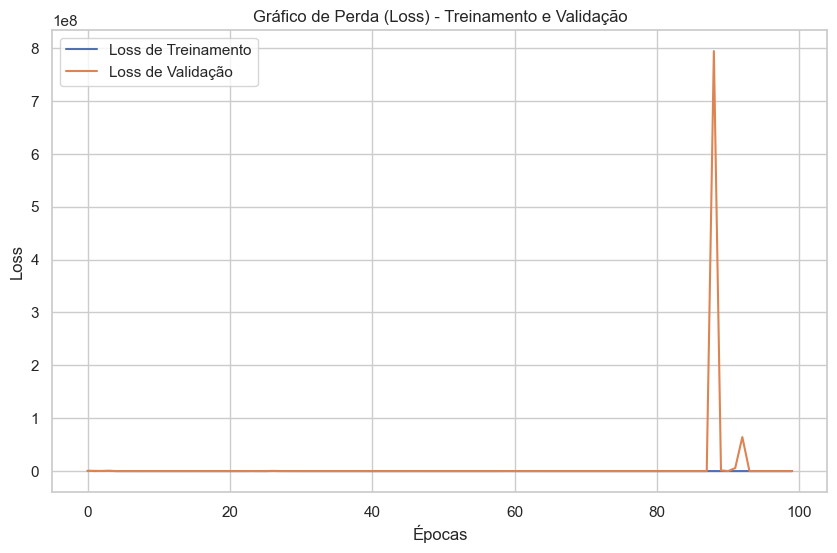

In [107]:
y_pred = evaluate_model(model, X_val, y_val)

num_instances_to_show = 10
print("Comparação de previsões para algumas instâncias de validação:")
for i in range(num_instances_to_show):
    print(f"Instância {i+1}:")
    print(f"Sequência de Entrada: {X_val[i].flatten()}")
    print(f"Valor Real: {y_val[i]}")
    print(f"Previsão: {y_pred[i]}\n")

plot_loss(history)

In [108]:
evaluate_model_with_window(model, X_val, y_val, window_size=7)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Acurácia dentro da janela de 7 dias: 13.66%


0.13662790697674418

### Resultados com LSTM Mais Profunda e CNN

Ao aumentar a profundidade da rede LSTM, o resultado apresentou uma leve melhora, mas ainda não foi satisfatório, alcançando uma acurácia de 0.35. Para tentar melhorar ainda mais, utilizamos uma rede neural convolucional (CNN) unidimensional, conhecida por sua capacidade de identificar padrões em séries temporais de forma mais robusta. No entanto, os resultados foram ainda menos positivos, com uma acurácia de apenas 0.13. 

#### Observações

Os modelos, tanto LSTM quanto CNN, mantiveram uma taxa de erro muito parecida ao longo das épocas, sugerindo que não estavam aprendendo de maneira eficaz. Isso indica que as informações contidas nos padrões das datas das visitas dos clientes não são suficientes para prever a próxima visita com precisão. Fatores adicionais, como o tipo de serviço, dia da semana, mês, e informações sazonais, poderiam potencialmente melhorar a previsão, mas não estão disponíveis no dataset atual.

### Mudança na Abordagem

Dado o desempenho insatisfatório dos modelos baseados em redes neurais, decidimos mudar a pergunta. Em vez de prever exatamente o dia da próxima visita do cliente, a nova abordagem será prever se o cliente voltará à barbearia no próximo mês ou nos próximos 45 dias. Essa pergunta é mais ampla e pode ser resolvida com técnicas de aprendizado de máquina mais tradicionais, como Random Forest Classifiers.

#### Criação de Novas Features

Para melhorar a capacidade preditiva do modelo, adicionamos novas features para cada visita:

- *Número de Dias Desde a Primeira Visita*: Calcula o número de dias entre a visita atual e a primeira visita do cliente.
- *Número de Dias Desde a Última Visita*: Calcula o número de dias entre a visita atual e a visita anterior.
- *Número Total de Visitas Até o Momento*: Conta o número total de visitas do cliente até a visita atual.
- *Valor Médio de Dias Entre as Visitas*: Calcula a média dos dias entre as visitas do cliente até o momento atual.
- *Desvio Padrão do Valor Médio de Dias Entre as Visitas*: Calcula o desvio padrão dos dias entre as visitas do cliente.
- *Variáveis de Lag*: Capturam informações das últimas visitas do cliente, adicionando contexto temporal. Por exemplo, lag_1 representa o número de dias desde a última visita, lag_2 desde a penúltima visita, e assim por diante.

In [138]:
df = pd.read_csv('presenca_clientes_limpo.csv')

df['data'] = pd.to_datetime(df['data'])
df['primeira_visita'] = pd.to_datetime(df['primeira_visita'])
df['month'] = df['data'].dt.month

df['days_since_first_visit'] = (df['data'] - df['primeira_visita']).dt.days
df['days_since_last_visit'] = df.groupby('id')['data'].diff().dt.days
df['days_since_last_visit'].fillna(0, inplace=True)

df = df[df['data'].dt.year < 2024]

df.head()

C:\Users\fredb\AppData\Local\Temp\ipykernel_19216\1132592558.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['days_since_last_visit'].fillna(0, inplace=True)


,id,data,primeira_visita,month,days_since_first_visit,days_since_last_visit
0,1,2016-07-28,2016-07-28,7,0,0.0
1,1,2016-10-27,2016-07-28,10,91,91.0
2,1,2016-12-20,2016-07-28,12,145,54.0
3,1,2017-03-03,2016-07-28,3,218,73.0
4,1,2017-04-26,2016-07-28,4,272,54.0


In [139]:
min_visits = 6
customer_counts = df['id'].value_counts()
valid_customers = customer_counts[customer_counts >= min_visits].index
df = df[df['id'].isin(valid_customers)]
df.head()

,id,data,primeira_visita,month,days_since_first_visit,days_since_last_visit
0,1,2016-07-28,2016-07-28,7,0,0.0
1,1,2016-10-27,2016-07-28,10,91,91.0
2,1,2016-12-20,2016-07-28,12,145,54.0
3,1,2017-03-03,2016-07-28,3,218,73.0
4,1,2017-04-26,2016-07-28,4,272,54.0


In [140]:
def calculate_past_features(group):
    features = []
    for i in range(len(group)):
        past_visits = group.iloc[:i]
        current_visit = group.iloc[i]
        
        feature = {
            'total_visits': len(past_visits),
            'mean_days_between_visits': past_visits['days_since_last_visit'].mean() if len(past_visits) > 0 else 0,
            'std_days_between_visits': past_visits['days_since_last_visit'].std() if len(past_visits) > 0 else 0,
            'days_since_first_visit': current_visit['days_since_first_visit'],
            'days_since_last_visit': current_visit['days_since_last_visit'],
            'lag_1_days_since_last_visit': past_visits['days_since_last_visit'].values[-1] if len(past_visits) >= 1 else 0,
            'lag_2_days_since_last_visit': past_visits['days_since_last_visit'].shift(1).values[-2] if len(past_visits) >= 2 else 0,
            'lag_3_days_since_last_visit': past_visits['days_since_last_visit'].shift(2).values[-3] if len(past_visits) >= 3 else 0,
            'will_return': 0
        }
        
        if i + 1 < len(group):
            next_visit = group.iloc[i + 1]
            feature['will_return'] = 1 if (next_visit['data'] - current_visit['data']).days <= 45 else 0
        
        features.append(feature)
    
    return pd.DataFrame(features)

In [141]:
features_df = pd.concat([calculate_past_features(group) for _, group in df.groupby('id')])
features_df = features_df.dropna()

features_df = features_df[features_df['total_visits'] >= 6]

features = ['total_visits',
            'mean_days_between_visits',
            'std_days_between_visits',
            'days_since_first_visit',
            'days_since_last_visit',
            'lag_1_days_since_last_visit',
            'lag_2_days_since_last_visit',
            'lag_3_days_since_last_visit',]
target = 'will_return'

X = features_df[features]
y = features_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_train.head()

,total_visits,mean_days_between_visits,std_days_between_visits,days_since_first_visit,days_since_last_visit,lag_1_days_since_last_visit,lag_2_days_since_last_visit,lag_3_days_since_last_visit
9,9,39.555556,19.216602,388,32.0,20.0,56.0,49.0
8,8,44.125000,63.210391,427,74.0,10.0,13.0,16.0
146,146,12.554795,6.924251,1841,8.0,14.0,16.0,8.0
82,82,29.792683,23.016761,2478,35.0,23.0,21.0,17.0
43,43,20.697674,15.114696,932,42.0,22.0,28.0,13.0


In [142]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_prob_test = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train, y_pred_train),
            'precision': precision_score(y_train, y_pred_train),
            'recall': recall_score(y_train, y_pred_train),
            'f1': f1_score(y_train, y_pred_train),
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_pred_test),
            'precision': precision_score(y_test, y_pred_test),
            'recall': recall_score(y_test, y_pred_test),
            'f1': f1_score(y_test, y_pred_test),
            'roc_auc': roc_auc_score(y_test, y_prob_test)
        }
    }
    
    return metrics

100%|██████████| 100/100 [01:20<00:00,  1.25it/s]

O melhor número de estimadores é 63 com acurácia de 0.8239 no conjunto de teste


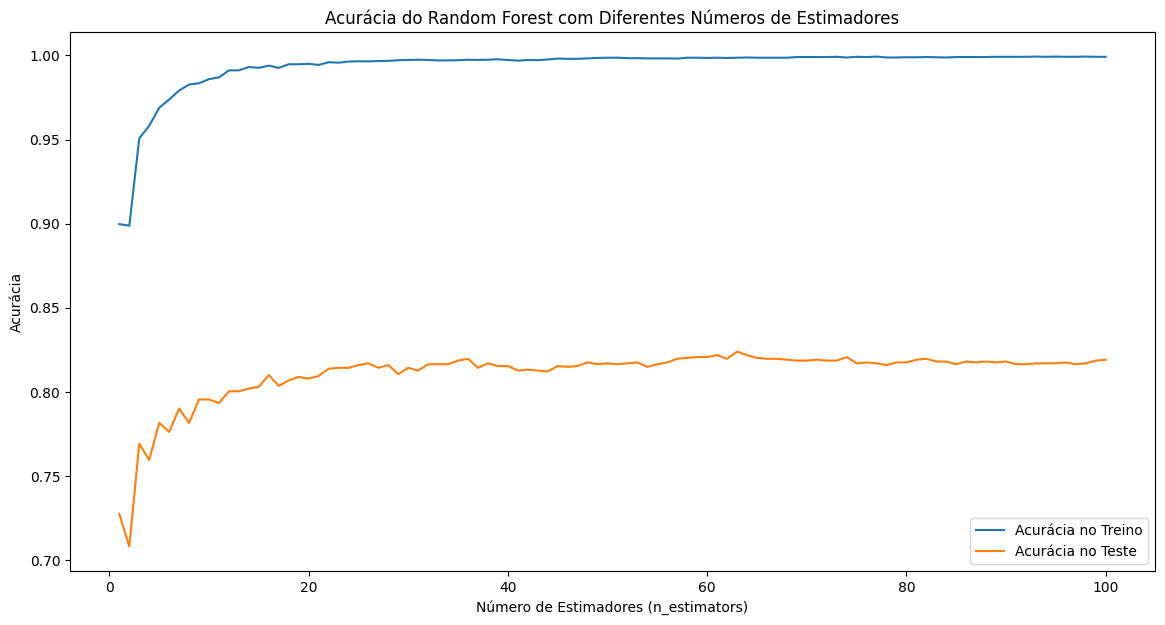

In [143]:
from tqdm import tqdm

max_depth = 20
n_estimators_range = range(1, 101)
train_accuracies = []
test_accuracies = []

for n in tqdm(n_estimators_range):
    model = RandomForestClassifier(n_estimators=n, max_depth=max_depth, random_state=42)
    metrics = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    
    train_accuracies.append(metrics['train']['accuracy'])
    test_accuracies.append(metrics['test']['accuracy'])

best_n_estimators = n_estimators_range[test_accuracies.index(max(test_accuracies))]
print(f'O melhor número de estimadores é {best_n_estimators} com acurácia de {max(test_accuracies):.4f} no conjunto de teste')

plt.figure(figsize=(14, 7))
plt.plot(n_estimators_range, train_accuracies, label='Acurácia no Treino')
plt.plot(n_estimators_range, test_accuracies, label='Acurácia no Teste')
plt.xlabel('Número de Estimadores (n_estimators)')
plt.ylabel('Acurácia')
plt.title('Acurácia do Random Forest com Diferentes Números de Estimadores')
plt.legend()
plt.show()

100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


A melhor profundidade da árvore é 9 com acurácia de 0.8282 no conjunto de teste


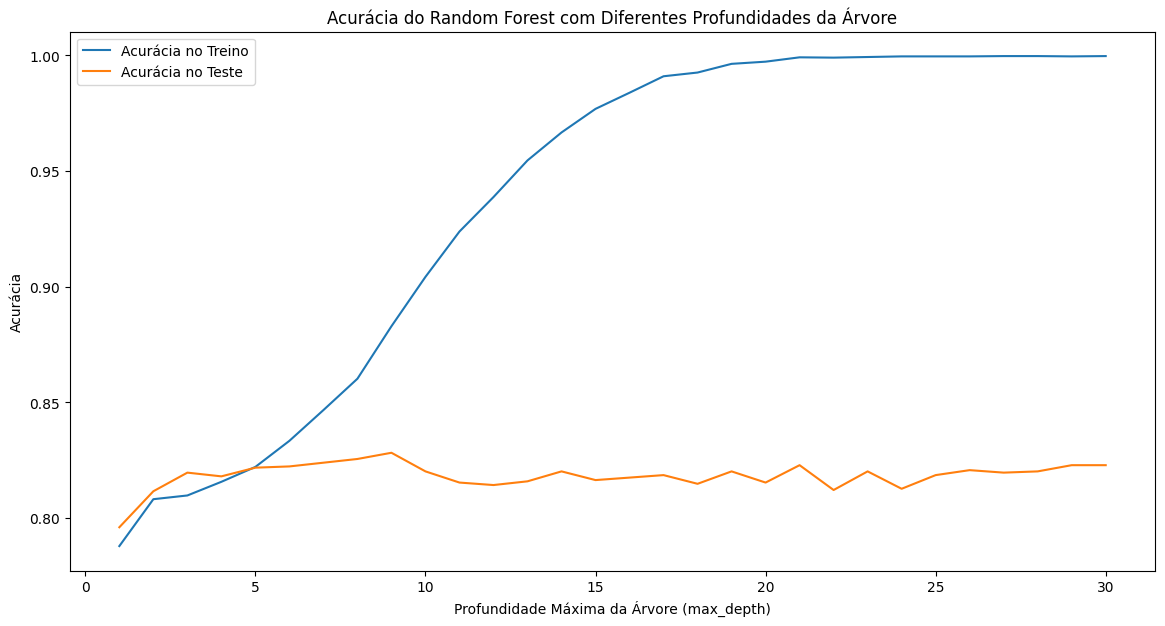

In [144]:
n_estimators = 40
max_depth_range = range(1, 31)
train_accuracies = []
test_accuracies = []

for depth in tqdm(max_depth_range):
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=depth, random_state=42)
    metrics = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    
    train_accuracies.append(metrics['train']['accuracy'])
    test_accuracies.append(metrics['test']['accuracy'])

best_max_depth = max_depth_range[test_accuracies.index(max(test_accuracies))]
print(f'A melhor profundidade da árvore é {best_max_depth} com acurácia de {max(test_accuracies):.4f} no conjunto de teste')

plt.figure(figsize=(14, 7))
plt.plot(max_depth_range, train_accuracies, label='Acurácia no Treino')
plt.plot(max_depth_range, test_accuracies, label='Acurácia no Teste')
plt.xlabel('Profundidade Máxima da Árvore (max_depth)')
plt.ylabel('Acurácia')
plt.title('Acurácia do Random Forest com Diferentes Profundidades da Árvore')
plt.legend()
plt.show()

#### Desempenho Inicial

Ao utilizar um Random Forest com profundidade máxima de 20, observamos um resultado promissor com uma acurácia de 0.82 no conjunto de teste. No entanto, identificamos um claro sinal de overfitting:

- **Acurácia no Treino**: A acurácia no conjunto de treino é praticamente 1, indicando que o modelo decorou os dados de treino.
- **Acurácia no Teste**: A acurácia no conjunto de teste é de aproximadamente 0.8, que é significativamente menor do que no conjunto de treino.

#### Identificação de Overfitting

Esse comportamento é um indicativo clássico de overfitting, onde o modelo se ajusta muito bem aos dados de treino, mas não generaliza bem para dados novos. Para mitigar esse problema, vamos realizar um grid search para encontrar a melhor combinação de parâmetros (`max_depth` e `n_estimators`) para o Random Forest.

Grid Search: n_estimators: 100%|██████████| 59/59 [11:31<00:00, 11.73s/it]


Melhor combinação de parâmetros: n_estimators=46.0, max_depth=9.0 com acurácia de 0.8293 no conjunto de teste


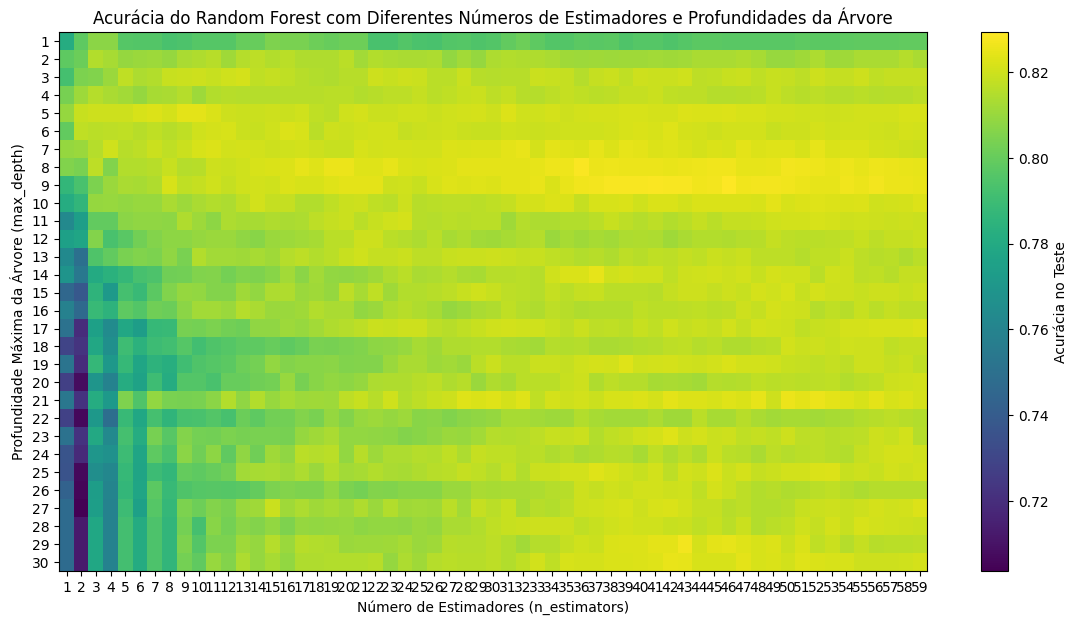

In [145]:
n_estimators_range = range(1, 60)
max_depth_range = range(1, 31)
grid_search_results = []

for n in tqdm(n_estimators_range, desc="Grid Search: n_estimators"):
    for depth in tqdm(max_depth_range, desc=f"Grid Search: max_depth (n_estimators={n})", leave=False):
        model = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=42)
        metrics = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
        
        grid_search_results.append({
            'n_estimators': n,
            'max_depth': depth,
            'train_accuracy': metrics['train']['accuracy'],
            'test_accuracy': metrics['test']['accuracy']
        })

grid_search_df = pd.DataFrame(grid_search_results)

best_params = grid_search_df.loc[grid_search_df['test_accuracy'].idxmax()]
print(f"Melhor combinação de parâmetros: n_estimators={best_params['n_estimators']}, max_depth={best_params['max_depth']} com acurácia de {best_params['test_accuracy']:.4f} no conjunto de teste")

pivot_table = grid_search_df.pivot(index='max_depth', columns='n_estimators', values='test_accuracy')
plt.figure(figsize=(14, 7))
plt.title('Acurácia do Random Forest com Diferentes Números de Estimadores e Profundidades da Árvore')
plt.xlabel('Número de Estimadores (n_estimators)')
plt.ylabel('Profundidade Máxima da Árvore (max_depth)')
plt.imshow(pivot_table, aspect='auto', cmap='viridis')
plt.colorbar(label='Acurácia no Teste')
plt.xticks(np.arange(len(n_estimators_range)), n_estimators_range)
plt.yticks(np.arange(len(max_depth_range)), max_depth_range)
plt.show()

## Segmentação de Clientes

A segmentação de clientes é uma tarefa crucial para qualquer negócio, pois permite entender melhor os diferentes perfis de clientes que contribuem para o sucesso da empresa. Conhecer esses perfis ajuda a:

- **Identificar Clientes Valiosos**: Entender quais clientes geram mais receita e são mais lucrativos.
- **Personalizar Ofertas e Incentivos**: Focar em clientes que são mais interessantes para o negócio, oferecendo incentivos personalizados para aumentar a retenção e a satisfação.
- **Atrair Novos Clientes Semelhantes**: Desenvolver estratégias de marketing para atrair novos clientes que possuem perfis semelhantes aos dos clientes mais valiosos.

In [159]:
df = pd.read_csv('presenca_clientes_limpo.csv', parse_dates=['data', 'primeira_visita'])
df.head()

,id,data,primeira_visita
0,1,2016-07-28,2016-07-28
1,1,2016-10-27,2016-07-28
2,1,2016-12-20,2016-07-28
3,1,2017-03-03,2016-07-28
4,1,2017-04-26,2016-07-28


#### Criação das Features para Segmentação

Para realizar a segmentação de clientes, criamos quatro principais features:

1. **Número de Visitas**: Quantidade total de visitas que o cliente fez à barbearia.
2. **Tempo como Cliente**: Duração do relacionamento do cliente com a barbearia, desde a primeira visita.
3. **Média de Dias entre Visitas**: Tempo médio entre as visitas do cliente.
4. **Frequência Anual**: Número de visitas por ano, em média.

In [160]:
def calcular_media_dias_entre_visitas(dates):
    diffs = dates.diff().dropna()
    if len(diffs) > 0:
        return diffs.mean().days
    else:
        return 0

clientes = df.groupby('id').agg(
    primeira_visita=('primeira_visita', 'first'),
    ultima_visita=('data', 'max'),
    numero_visitas=('data', 'count'),
    tempo_como_cliente=('data', lambda x: (x.max() - x.min()).days),
    media_dias_entre_visitas=('data', calcular_media_dias_entre_visitas),
).reset_index()

clientes['frequencia_anual'] = clientes['numero_visitas'] / (clientes['tempo_como_cliente'] / 365)

clientes.replace([np.inf, -np.inf], np.nan, inplace=True)
clientes.fillna(0, inplace=True)

clientes.head()

,id,primeira_visita,ultima_visita,numero_visitas,tempo_como_cliente,media_dias_entre_visitas,frequencia_anual
0,1,2016-07-28,2021-10-26,17,1916,119,3.238518
1,2,2016-07-28,2022-07-12,64,2175,34,10.740230
2,3,2016-07-28,2022-03-30,66,2071,31,11.632062
3,4,2016-07-28,2017-03-15,5,230,57,7.934783
4,5,2016-07-28,2016-08-09,2,12,12,60.833333


#### Tratamento dos Dados

- **Remoção de Outliers**: Decidimos remover os outliers do dataset, pois eles poderiam enviesar a segmentação e afetar a qualidade dos clusters formados.
- **Normalização dos Dados**: A normalização é um passo importante, especialmente para o algoritmo K-Means, que é sensível às diferenças de escala entre as features. Normalizamos os dados para garantir que todas as features tenham a mesma importância na segmentação.

In [161]:
def remover_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

features = ['numero_visitas', 'tempo_como_cliente', 'frequencia_anual', 'media_dias_entre_visitas']
clientes = remover_outliers(clientes, features)

In [162]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clientes[features])

clientes_normalizados = pd.DataFrame(scaled_features, columns=features)
clientes_normalizados['id'] = clientes['id']

clientes_normalizados.head()

,numero_visitas,tempo_como_cliente,frequencia_anual,media_dias_entre_visitas,id
0,-0.132818,-0.121134,0.487424,0.522079,NaN
1,-0.394367,0.019521,-0.223737,2.621638,NaN
2,-0.394367,-0.329692,0.430531,0.884072,NaN
3,0.521055,1.782562,-0.259190,1.849386,4.0
4,0.128731,0.101974,0.487424,0.425547,NaN


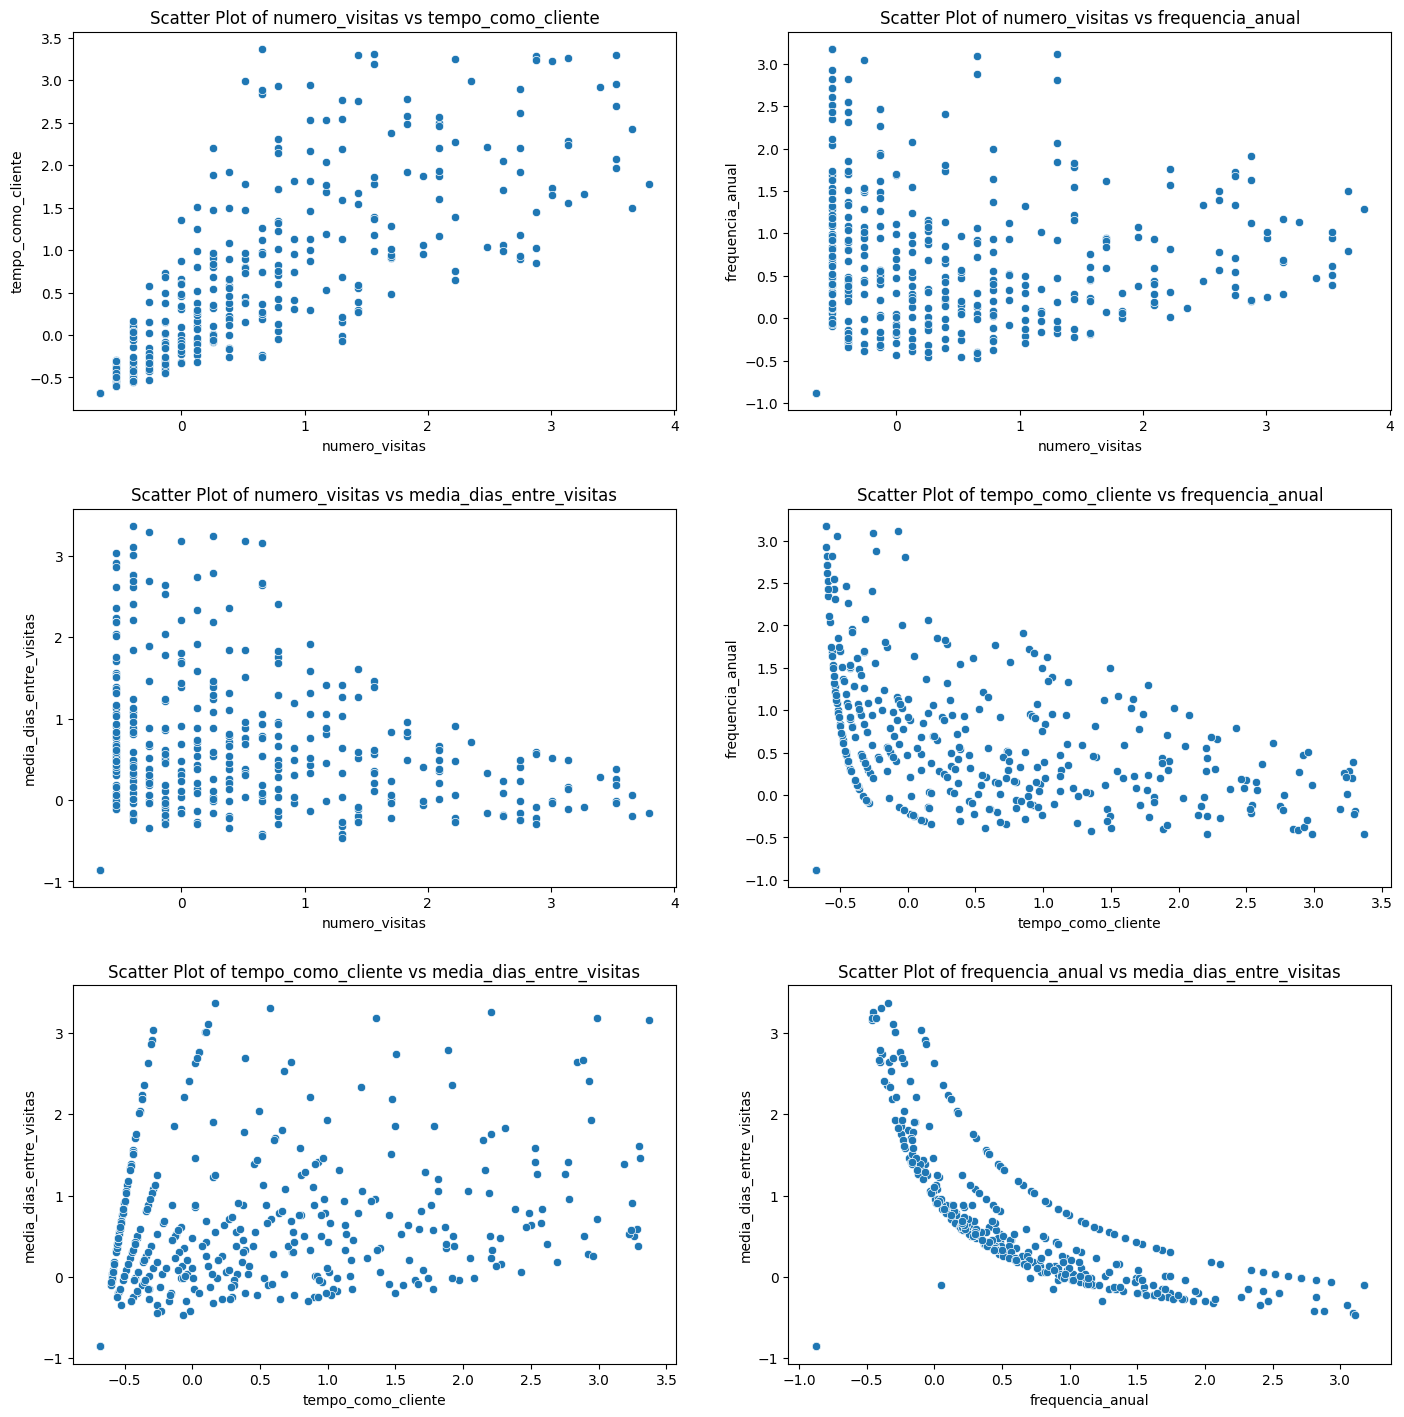

In [163]:
features = ['numero_visitas', 'tempo_como_cliente', 'frequencia_anual', 'media_dias_entre_visitas']
combinations = [(features[i], features[j]) for i in range(len(features)) for j in range(i+1, len(features))]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

fig.tight_layout(pad=5.0)

for ax, (feature1, feature2) in zip(axes.flatten(), combinations):
    sns.scatterplot(data=clientes_normalizados, x=feature1, y=feature2, ax=ax)
    ax.set_title(f'Scatter Plot of {feature1} vs {feature2}')

plt.show()

In [164]:
from sklearn.cluster import KMeans
def segment_clients_and_plot(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clientes_normalizados['Cluster'] = kmeans.fit_predict(scaled_features)

    combinations = [(features[i], features[j]) for i in range(len(features)) for j in range(i+1, len(features))]

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    fig.tight_layout(pad=5.0)

    for ax, (feature1, feature2) in zip(axes.flatten(), combinations):
        sns.scatterplot(data=clientes_normalizados, x=feature1, y=feature2, hue='Cluster', palette='viridis', ax=ax)
        ax.set_title(f'Scatter Plot of {feature1} vs {feature2}')

    plt.show()

c:\Users\fredb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


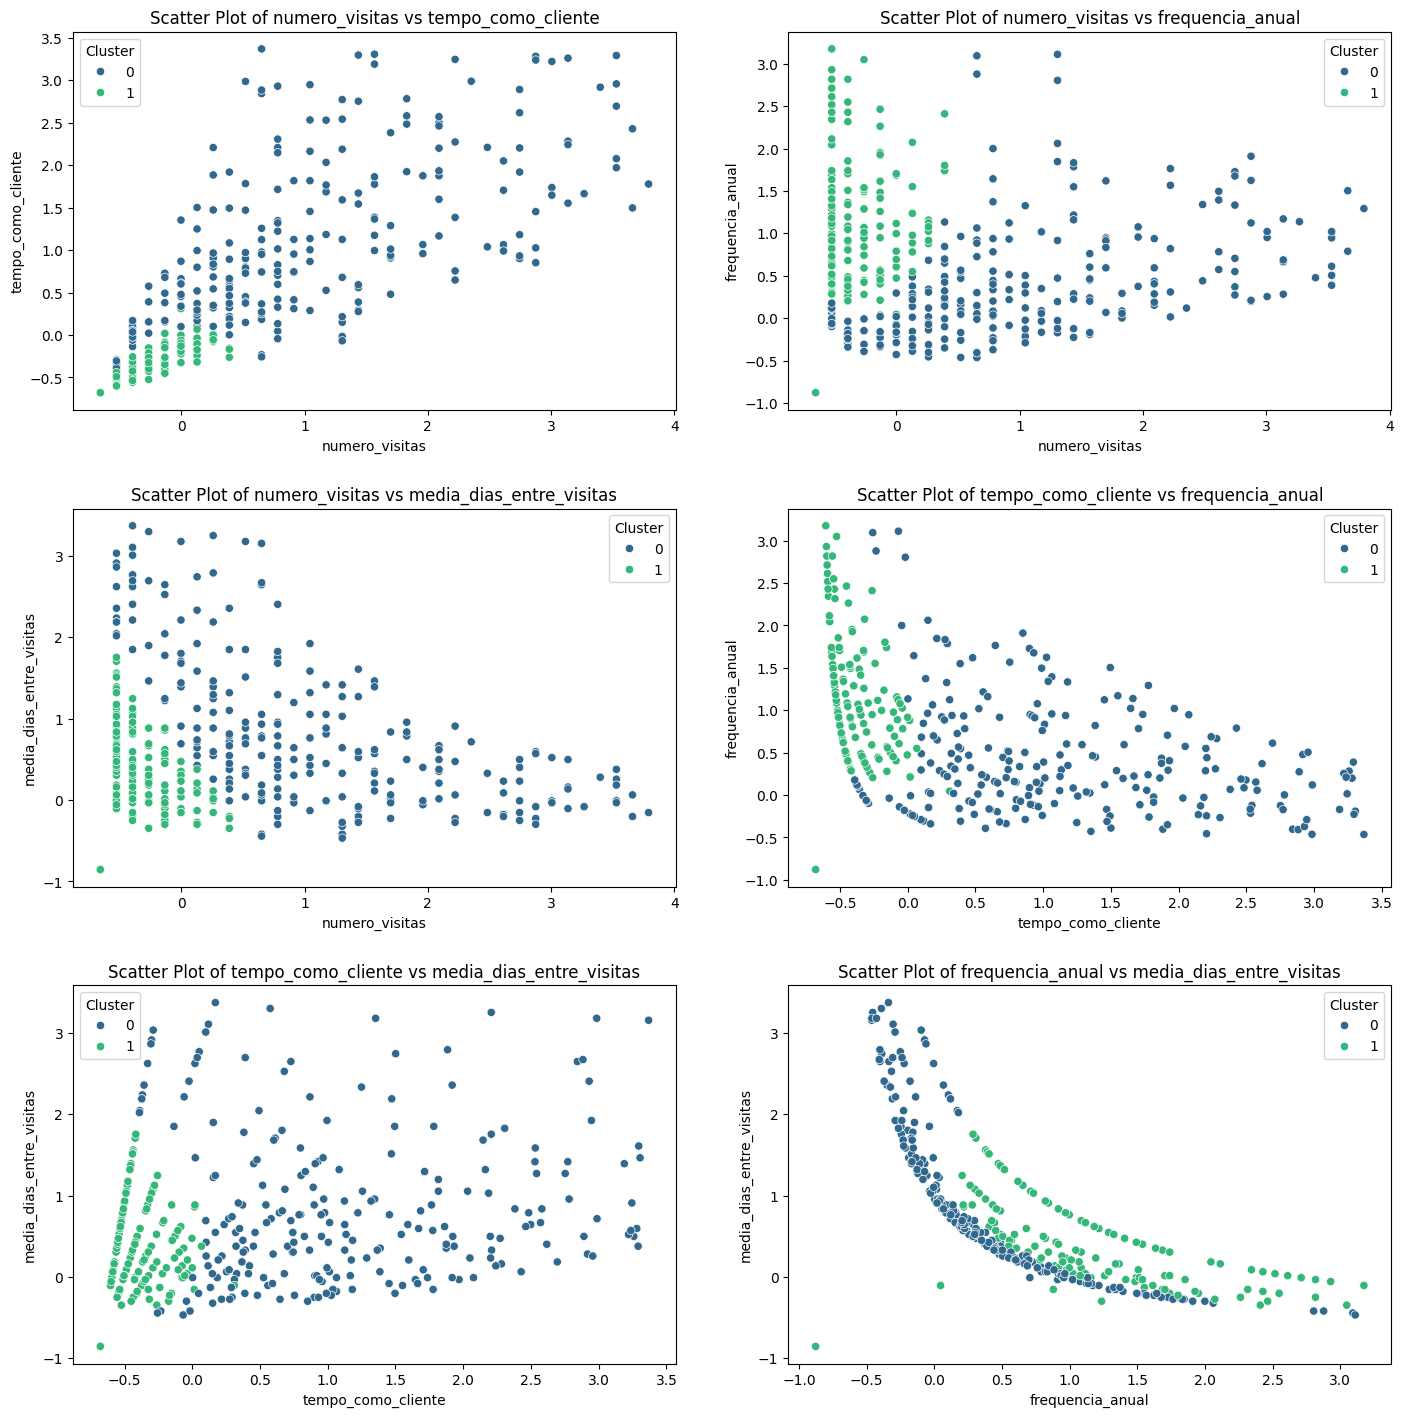

In [165]:
segment_clients_and_plot(2)

c:\Users\fredb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


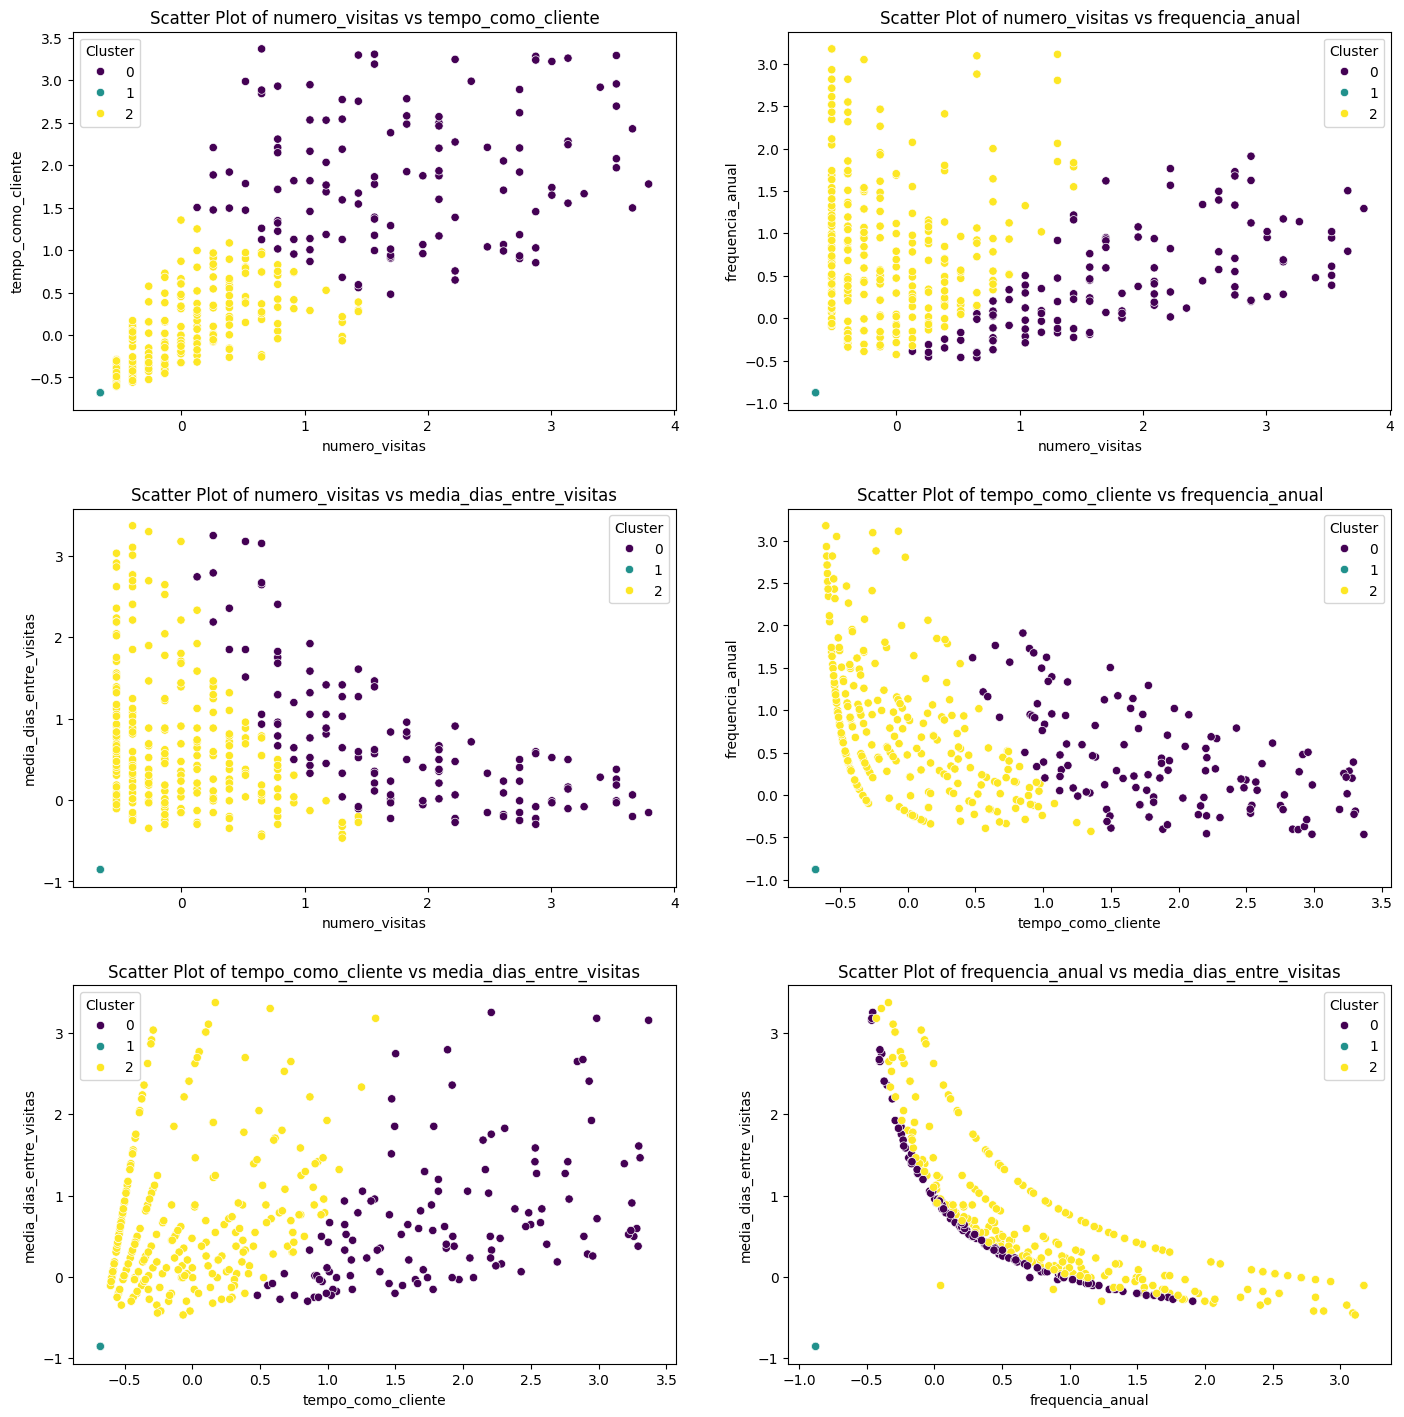

In [166]:
segment_clients_and_plot(3)

c:\Users\fredb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


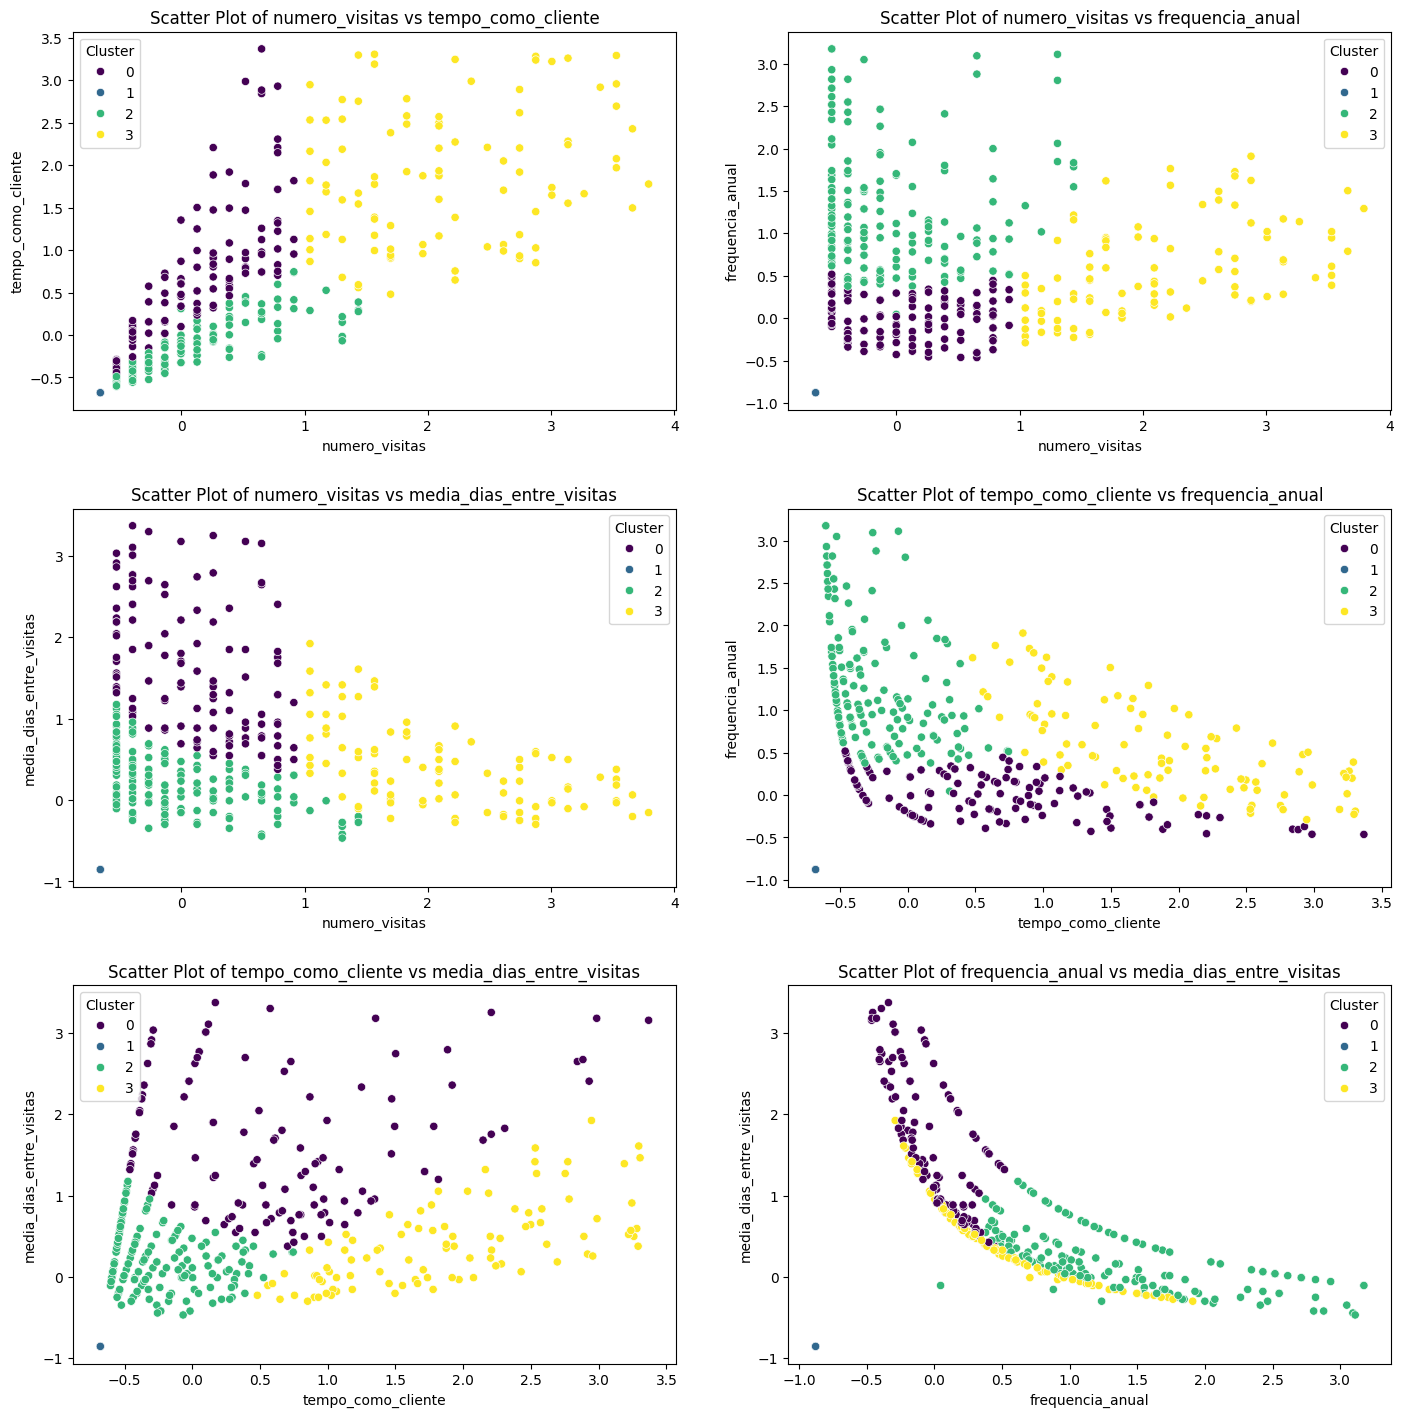

In [167]:
segment_clients_and_plot(4)

c:\Users\fredb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


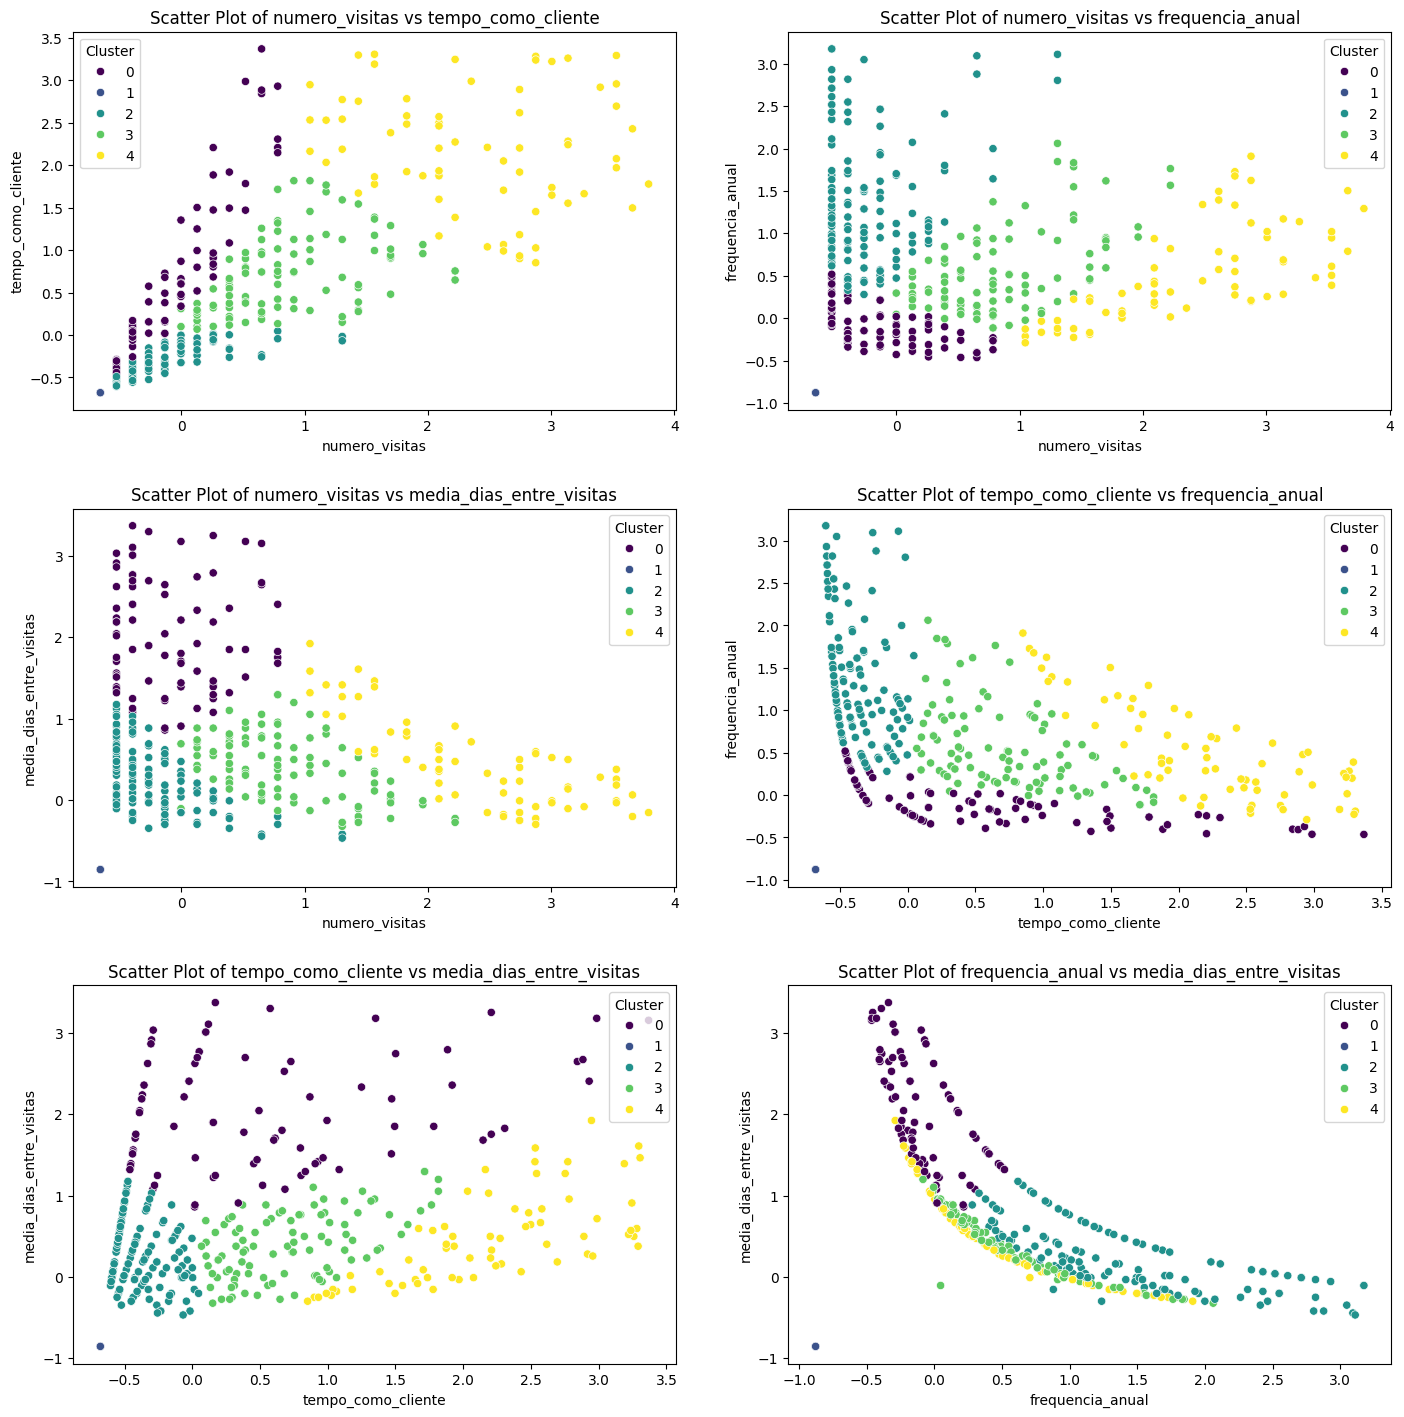

In [168]:
segment_clients_and_plot(5)